## **Scania truck APS failure prediction**

# Introduction

Heavy duty vehicle is essential part of our transportation system. In heavy duty vehicle we use Air Pressure System in various parts like break and gear system. Basically we use the APS to control the vehicle, for that it become very important to do regular maintenance otherwise it can lead the accident and high cost maintenance. To deal with this problem Scania truck wants to minimize the cost of maintenance using Machine Learning algorithm. Dataset consist of data collected from heavy Scania Truck in everyday usage.
Our task is to predict whether a given failure is occurred due to specific component of the APS or not. This may help in avoiding failure during the operation and thereby reducing maintenance cost.


# ML Formulation 

This is a binary classification problem. There are two classes positive and negative. Positive class tells us that failure occurred due to the ASP and negative class tells us that failure did not occurred due to ASP. We have to build a ML model which can take data from the various sensors and predict that failure was happened due to APS or not. It will going save the time and reduce the cost of maintenance

# Business Constrain 

Latency must be low and model should be able to predict the failure in ASP as soon as quickly.
Cost of misclassification is very high specially False negative and lead the high cost of maintenance

#  Data overview 

Data consists of two sets of file

i. Train.csv

ii. Test.csv

Training set which have 60000 data points and 171 features out of which 59000 belong to the negative class and 1000 belong to the positive class. Test set contain 16000 data points out of which 15625 belongs to the negative class and 375 data point belong to positive class. The attribute name of the data has been anonymized for proprietary reason. It consists of both single numerical counters and histogram consisting of bin with different conditions. Data is highly imbalance and there are lots of missing values. In dataset have total 171 features out of this feature, 70 features are histogram features

# Performance Metric 

In this problem we can use Macro-F1 score as our performance metric to calculate the cost_1 and cost_2. Basically in Macro F1 score we calculate the F1 score of each class separately and compute the average of it. Macro-F1 score best value is 1 and worst value is 0. With the help of cost_1 and cost_2 we can calculate the Total cost of maintenance.

# Dataset Link

https://archive.ics.uci.edu/ml/datasets/APS+Failure+at+Scania+Trucks

https://www.kaggle.com/c/scania-truck-failures

# **Exploratory Data Analysis and Data Preprocessing**

In [ ]:
# Mounting google drive on notebook

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Important Libraries

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
#from fancyimpute import SoftImpute
from sklearn.feature_selection import RFE
from sklearn.tree import DecisionTreeClassifier
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from collections import Counter
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import RFE
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.experimental import enable_iterative_imputer
from imblearn.over_sampling import SMOTE
from sklearn.impute import IterativeImputer
from sklearn.linear_model import Ridge
import seaborn as sns
import joblib
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_curve,auc
from sklearn.metrics import confusion_matrix
from sklearn.naive_bayes import GaussianNB
from scipy.stats import uniform,randint
from tqdm import tqdm
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.preprocessing import MinMaxScaler
from lightgbm import LGBMClassifier
from sklearn.metrics import f1_score
from sklearn.metrics import precision_recall_curve
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import AdaBoostClassifier
#from prettytable import PrettyTable
import pickle


import warnings
warnings.filterwarnings("ignore")




# Loading Train Data

In [ ]:
# loading the train_csv data form drve 
train_df = pd.read_csv('/content/drive/MyDrive/aps_failure_training_set.csv',header='infer',skiprows=20)
train_df.head()

,class,aa_000,ab_000,ac_000,ad_000,ae_000,af_000,ag_000,ag_001,ag_002,ag_003,ag_004,ag_005,ag_006,ag_007,ag_008,ag_009,ah_000,ai_000,aj_000,ak_000,al_000,am_0,an_000,ao_000,ap_000,aq_000,ar_000,as_000,at_000,au_000,av_000,ax_000,ay_000,ay_001,ay_002,ay_003,ay_004,ay_005,ay_006,...,db_000,dc_000,dd_000,de_000,df_000,dg_000,dh_000,di_000,dj_000,dk_000,dl_000,dm_000,dn_000,do_000,dp_000,dq_000,dr_000,ds_000,dt_000,du_000,dv_000,dx_000,dy_000,dz_000,ea_000,eb_000,ec_00,ed_000,ee_000,ee_001,ee_002,ee_003,ee_004,ee_005,ee_006,ee_007,ee_008,ee_009,ef_000,eg_000
0,neg,76698,na,2130706438,280,0,0,0,0,0,0,37250,1432864,3664156,1007684,25896,0,2551696,0,0,0,0,0,4933296,3655166,1766008,1132040,0,0,0,0,1012,268,0,0,0,0,0,469014,4239660,...,18,5330690,4732,1126,0,0,0,0,0,0,0,0,62282,85908,32790,0,0,202710,37928,14745580,1876644,0,0,0,0,2801180,2445.8,2712,965866,1706908,1240520,493384,721044,469792,339156,157956,73224,0,0,0
1,neg,33058,na,0,na,0,0,0,0,0,0,18254,653294,1720800,516724,31642,0,1393352,0,68,0,0,0,2560898,2127150,1084598,338544,0,0,0,0,0,0,0,0,0,0,0,71510,772720,...,na,na,3312,522,0,0,0,0,0,0,0,0,33736,36946,5936,0,0,103330,16254,4510080,868538,0,0,0,0,3477820,2211.76,2334,664504,824154,421400,178064,293306,245416,133654,81140,97576,1500,0,0
2,neg,41040,na,228,100,0,0,0,0,0,0,1648,370592,1883374,292936,12016,0,1234132,0,0,0,0,0,2371990,2173634,300796,153698,0,0,0,0,358,110,0,0,0,0,0,0,870456,...,0,2341048,1494,152,0,0,0,0,0,0,0,0,13876,38182,8138,0,0,65772,10534,300240,48028,0,0,0,0,1040120,1018.64,1020,262032,453378,277378,159812,423992,409564,320746,158022,95128,514,0,0
3,neg,12,0,70,66,0,10,0,0,0,318,2212,3232,1872,0,0,0,2668,0,0,0,642,3894,10184,7554,10764,1014,0,0,0,0,60,6,0,0,0,0,0,0,0,...,0,2578,76,62,0,0,0,0,0,0,0,0,232,0,0,2014,370,48,18,15740,1822,20174,44,0,0,0,1.08,54,5670,1566,240,46,58,44,10,0,0,0,4,32
4,neg,60874,na,1368,458,0,0,0,0,0,0,43752,1966618,1800340,131646,4588,0,1974038,0,226,0,0,0,3230626,2618878,1058136,551022,0,0,0,0,1788,642,0,0,0,0,42124,372236,2128914,...,0,3590004,2026,444,0,0,0,0,0,0,0,0,44946,62648,11506,0,0,149474,35154,457040,80482,98334,27588,0,0,21173050,1116.06,1176,404740,904230,622012,229790,405298,347188,286954,311560,433954,1218,0,0


In [ ]:
# derscribeing the data
train_df.describe()

,aa_000
count,6.000000e+04
mean,5.933650e+04
std,1.454301e+05
min,0.000000e+00
25%,8.340000e+02
50%,3.077600e+04
75%,4.866800e+04
max,2.746564e+06


In [ ]:
train_df.info() # informantion about the data

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60000 entries, 0 to 59999
Columns: 171 entries, class to eg_000
dtypes: int64(1), object(170)
memory usage: 78.3+ MB


### **Observation:** In train data there are total 60000 data point and 171 feature

Here we are going to replacing negetive class with 0 and positive class with 1 

In [ ]:
remap = {'neg':0, 'pos': 1}  # here we are neg and pos with 0 and 1
train_df = train_df.replace(remap)

In [ ]:
train_df.head()

,class,aa_000,ab_000,ac_000,ad_000,ae_000,af_000,ag_000,ag_001,ag_002,ag_003,ag_004,ag_005,ag_006,ag_007,ag_008,ag_009,ah_000,ai_000,aj_000,ak_000,al_000,am_0,an_000,ao_000,ap_000,aq_000,ar_000,as_000,at_000,au_000,av_000,ax_000,ay_000,ay_001,ay_002,ay_003,ay_004,ay_005,ay_006,...,db_000,dc_000,dd_000,de_000,df_000,dg_000,dh_000,di_000,dj_000,dk_000,dl_000,dm_000,dn_000,do_000,dp_000,dq_000,dr_000,ds_000,dt_000,du_000,dv_000,dx_000,dy_000,dz_000,ea_000,eb_000,ec_00,ed_000,ee_000,ee_001,ee_002,ee_003,ee_004,ee_005,ee_006,ee_007,ee_008,ee_009,ef_000,eg_000
0,0,76698,na,2130706438,280,0,0,0,0,0,0,37250,1432864,3664156,1007684,25896,0,2551696,0,0,0,0,0,4933296,3655166,1766008,1132040,0,0,0,0,1012,268,0,0,0,0,0,469014,4239660,...,18,5330690,4732,1126,0,0,0,0,0,0,0,0,62282,85908,32790,0,0,202710,37928,14745580,1876644,0,0,0,0,2801180,2445.8,2712,965866,1706908,1240520,493384,721044,469792,339156,157956,73224,0,0,0
1,0,33058,na,0,na,0,0,0,0,0,0,18254,653294,1720800,516724,31642,0,1393352,0,68,0,0,0,2560898,2127150,1084598,338544,0,0,0,0,0,0,0,0,0,0,0,71510,772720,...,na,na,3312,522,0,0,0,0,0,0,0,0,33736,36946,5936,0,0,103330,16254,4510080,868538,0,0,0,0,3477820,2211.76,2334,664504,824154,421400,178064,293306,245416,133654,81140,97576,1500,0,0
2,0,41040,na,228,100,0,0,0,0,0,0,1648,370592,1883374,292936,12016,0,1234132,0,0,0,0,0,2371990,2173634,300796,153698,0,0,0,0,358,110,0,0,0,0,0,0,870456,...,0,2341048,1494,152,0,0,0,0,0,0,0,0,13876,38182,8138,0,0,65772,10534,300240,48028,0,0,0,0,1040120,1018.64,1020,262032,453378,277378,159812,423992,409564,320746,158022,95128,514,0,0
3,0,12,0,70,66,0,10,0,0,0,318,2212,3232,1872,0,0,0,2668,0,0,0,642,3894,10184,7554,10764,1014,0,0,0,0,60,6,0,0,0,0,0,0,0,...,0,2578,76,62,0,0,0,0,0,0,0,0,232,0,0,2014,370,48,18,15740,1822,20174,44,0,0,0,1.08,54,5670,1566,240,46,58,44,10,0,0,0,4,32
4,0,60874,na,1368,458,0,0,0,0,0,0,43752,1966618,1800340,131646,4588,0,1974038,0,226,0,0,0,3230626,2618878,1058136,551022,0,0,0,0,1788,642,0,0,0,0,42124,372236,2128914,...,0,3590004,2026,444,0,0,0,0,0,0,0,0,44946,62648,11506,0,0,149474,35154,457040,80482,98334,27588,0,0,21173050,1116.06,1176,404740,904230,622012,229790,405298,347188,286954,311560,433954,1218,0,0


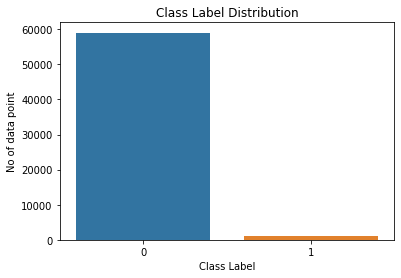

In [ ]:
# No of class label in data set

import seaborn as sns
x = train_df['class'].unique()
y = train_df['class'].value_counts()
sns.barplot(x, y)
plt.title('Class Label Distribution')
plt.xlabel('Class Label')
plt.ylabel('No of data point')
plt.show()


**Observation:** Data is highly Imbalance, 59000 point belong to negetive class and 1000 point belongs to positive class

In [ ]:
train_df = train_df.replace('na', np.NaN) # In train data replacing na value to np.NaN values

In [ ]:
# which data have zero std we are going to remove those feature 
def std_zero(x):
  x = x.astype(float)
  for i in x:
    if x[i].std() == 0:
      x = x.drop([i], axis = 1)
      print('feature with zero varience:', i)
x= train_df
std_zero(x)

feature with zero varience: cd_000


In [ ]:
# here we want to drop duplicate feature
train_df = train_df.T.drop_duplicates().T

In [ ]:
train_df.shape

(60000, 171)

**Observation:** 

1) In train data there are only one feature which standard daviation is 0, this feature not going to add any value to the model for that we remove this row

2) train data have only one duplicate row so we remove this row.


In [ ]:
# Loading the test dataset
test_data = pd.read_csv('/content/drive/MyDrive/aps_failure_test_set.csv', header = 'infer',skiprows= 20)

In [ ]:
test_data.head(3)

,class,aa_000,ab_000,ac_000,ad_000,ae_000,af_000,ag_000,ag_001,ag_002,ag_003,ag_004,ag_005,ag_006,ag_007,ag_008,ag_009,ah_000,ai_000,aj_000,ak_000,al_000,am_0,an_000,ao_000,ap_000,aq_000,ar_000,as_000,at_000,au_000,av_000,ax_000,ay_000,ay_001,ay_002,ay_003,ay_004,ay_005,ay_006,...,db_000,dc_000,dd_000,de_000,df_000,dg_000,dh_000,di_000,dj_000,dk_000,dl_000,dm_000,dn_000,do_000,dp_000,dq_000,dr_000,ds_000,dt_000,du_000,dv_000,dx_000,dy_000,dz_000,ea_000,eb_000,ec_00,ed_000,ee_000,ee_001,ee_002,ee_003,ee_004,ee_005,ee_006,ee_007,ee_008,ee_009,ef_000,eg_000
0,neg,60,0,20,12,0,0,0,0,0,2682,4736,3862,1846,0,0,0,3976,0,0,0,1520,2374,11516,9480,111258,470,0,0,0,0,58,26,0,0,0,0,0,0,0,...,0,6598,70,112,0,0,0,0,0,0,0,0,340,0,0,1100,574,232,66,780,882,0,4,0,0,0,465.5,90,7502,3156,1098,138,412,654,78,88,0,0,0,0
1,neg,82,0,68,40,0,0,0,0,0,0,748,12594,3636,0,0,0,5244,0,60,0,0,0,23174,18166,23686,1270,0,0,0,0,12,82,0,0,0,0,0,0,0,...,0,7918,78,40,0,0,0,0,0,0,0,0,352,0,0,3996,584,200,62,37580,3756,6368,36,0,0,0,2.86,102,10040,3310,1068,276,1620,116,86,462,0,0,0,0
2,neg,66002,2,212,112,0,0,0,0,0,199486,1358536,1952422,452706,25130,520,0,1891670,0,0,0,77898,110548,3605894,3291610,959756,286536,0,0,0,0,106,340,0,0,0,0,0,24286,681260,...,0,3613906,4218,692,0,0,0,0,0,0,0,0,25278,9438,2504,10262714,1278664,109700,19072,9520,4902,4434614,70900,0,0,26002880,2057.84,2158,396312,538136,495076,380368,440134,269556,1315022,153680,516,0,0,0


In [ ]:
# replacing the neg with 0, pos with 1 and na to np.NaN
test_data = test_data.replace('na', np.NaN)
remap = {'neg':0, 'pos': 1}
test_data = test_data.replace(remap)

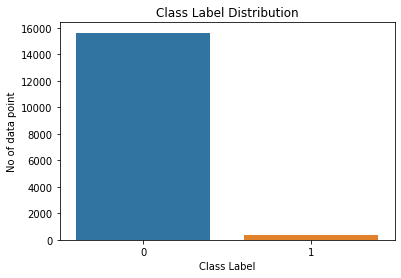

In [ ]:
# using seaborn we are going to plot the class label of dataset
x = test_data['class'].unique()
y = test_data['class'].value_counts()
sns.barplot(x, y)
plt.title('Class Label Distribution') # title of the plot
plt.xlabel('Class Label') # X label title
plt.ylabel('No of data point')# y label title 
plt.show()

In [ ]:
# removing the feature which have sdt is zero
def std_zero(x):
  x = x.astype(float)
  for i in x:
    if x[i].std() == 0:
      x = x.drop([i], axis = 1)
      print('feature with zero varience:', i)
x= test_data
std_zero(x)

feature with zero varience: cd_000


In [ ]:
# removing the duplicate feature
test_data = test_data.drop_duplicates()

In [ ]:
test_data.shape

(16000, 171)

In [ ]:
test_data.head(3)

,class,aa_000,ab_000,ac_000,ad_000,ae_000,af_000,ag_000,ag_001,ag_002,ag_003,ag_004,ag_005,ag_006,ag_007,ag_008,ag_009,ah_000,ai_000,aj_000,ak_000,al_000,am_0,an_000,ao_000,ap_000,aq_000,ar_000,as_000,at_000,au_000,av_000,ax_000,ay_000,ay_001,ay_002,ay_003,ay_004,ay_005,ay_006,...,db_000,dc_000,dd_000,de_000,df_000,dg_000,dh_000,di_000,dj_000,dk_000,dl_000,dm_000,dn_000,do_000,dp_000,dq_000,dr_000,ds_000,dt_000,du_000,dv_000,dx_000,dy_000,dz_000,ea_000,eb_000,ec_00,ed_000,ee_000,ee_001,ee_002,ee_003,ee_004,ee_005,ee_006,ee_007,ee_008,ee_009,ef_000,eg_000
0,0,60,0,20,12,0,0,0,0,0,2682,4736,3862,1846,0,0,0,3976,0,0,0,1520,2374,11516,9480,111258,470,0,0,0,0,58,26,0,0,0,0,0,0,0,...,0,6598,70,112,0,0,0,0,0,0,0,0,340,0,0,1100,574,232,66,780,882,0,4,0,0,0,465.5,90,7502,3156,1098,138,412,654,78,88,0,0,0,0
1,0,82,0,68,40,0,0,0,0,0,0,748,12594,3636,0,0,0,5244,0,60,0,0,0,23174,18166,23686,1270,0,0,0,0,12,82,0,0,0,0,0,0,0,...,0,7918,78,40,0,0,0,0,0,0,0,0,352,0,0,3996,584,200,62,37580,3756,6368,36,0,0,0,2.86,102,10040,3310,1068,276,1620,116,86,462,0,0,0,0
2,0,66002,2,212,112,0,0,0,0,0,199486,1358536,1952422,452706,25130,520,0,1891670,0,0,0,77898,110548,3605894,3291610,959756,286536,0,0,0,0,106,340,0,0,0,0,0,24286,681260,...,0,3613906,4218,692,0,0,0,0,0,0,0,0,25278,9438,2504,10262714,1278664,109700,19072,9520,4902,4434614,70900,0,0,26002880,2057.84,2158,396312,538136,495076,380368,440134,269556,1315022,153680,516,0,0,0


**Observation:** test data have 16000 data point and 171 feature, test data have same data distibution as train data

# Calculating Missing value from features

In [ ]:
# reference = https://www.thiscodeworks.com/python-find-out-the-percentage-of-missing-values-in-each-column-in-the-given-dataset-stack-overflow-python/607d4c3f6013b5001411542c

train_percent_missing = train_df.isnull().sum() * 100 / len(train_df)   # here we are calculating the missing values in feature 
train_miss_df = pd.DataFrame({'column_name': train_df.columns,
                                 'percent_missing': train_percent_missing}) # making the dataframe using Pandas 
train_miss_df.sort_values('percent_missing',ascending=False, inplace=True)  # here we are sorting the feature in descending from on the basis of missing value

In [ ]:
train_miss_df.head(10)

,column_name,percent_missing
br_000,br_000,82.106667
bq_000,bq_000,81.203333
bp_000,bp_000,79.566667
bo_000,bo_000,77.221667
ab_000,ab_000,77.215000
cr_000,cr_000,77.215000
bn_000,bn_000,73.348333
bm_000,bm_000,65.915000
bl_000,bl_000,45.461667
bk_000,bk_000,38.390000


Text(0, 0.5, 'Percantage of missing value')

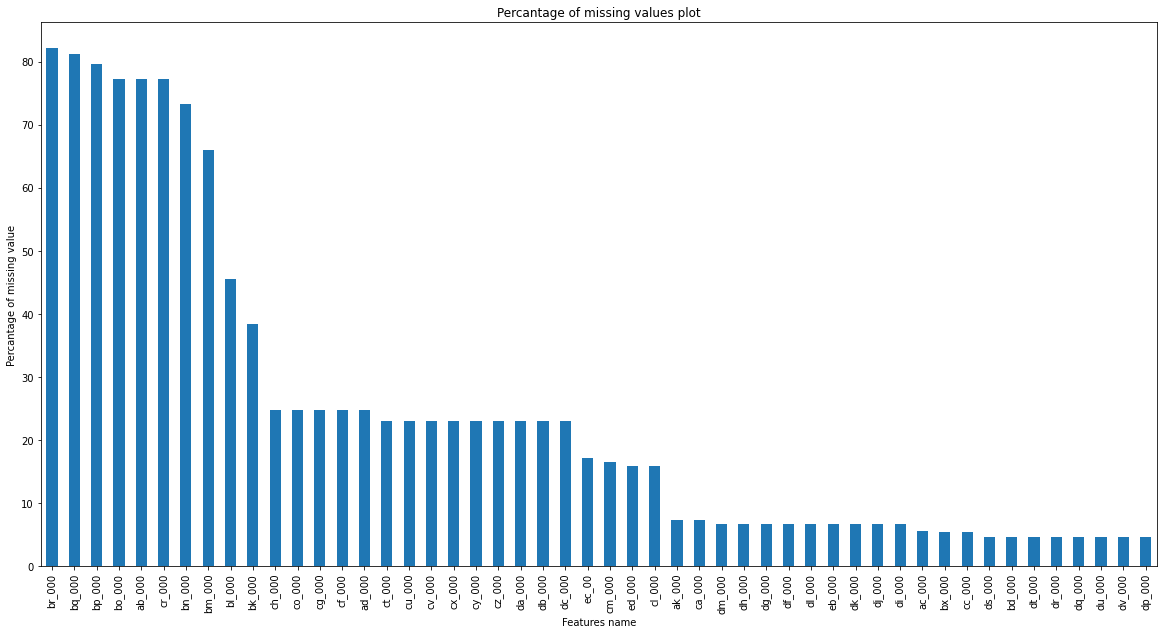

In [ ]:
# ploting the plotbar using feature and missing value

ax= train_miss_df['percent_missing'][:50].plot.bar(figsize=(20,10)) # here we are only ploting the top 50 feature which have maximum missing values 
ax.set_xlabel('Features name')
ax.set_title('Percantage of missing values plot')
ax.set_ylabel('Percantage of missing value')

## Here we are going to calculate the missing values in test data set

In [ ]:
# we are calculating the missing values 

test_percent_missing = test_data.isnull().sum() * 100 / len(test_data) # here we are calculating the missing percentage of values in feature
test_miss_df = pd.DataFrame({'column_name': test_data.columns,  # making the data freme using the feature name and missing persentage 
                                 'percent_missing': test_percent_missing})
test_miss_df.sort_values('percent_missing',ascending=False, inplace=True)  # here we are descending the feature according the missing values

In [ ]:
# printing the to 10 feature which have highest missing values
test_miss_df.head(10)

,column_name,percent_missing
br_000,br_000,82.05625
bq_000,bq_000,81.13125
bp_000,bp_000,79.50625
bo_000,bo_000,77.35000
ab_000,ab_000,77.26875
cr_000,cr_000,77.26875
bn_000,bn_000,73.20625
bm_000,bm_000,65.91250
bl_000,bl_000,45.16250
bk_000,bk_000,38.08750


Text(0, 0.5, 'Percantage of missing value')

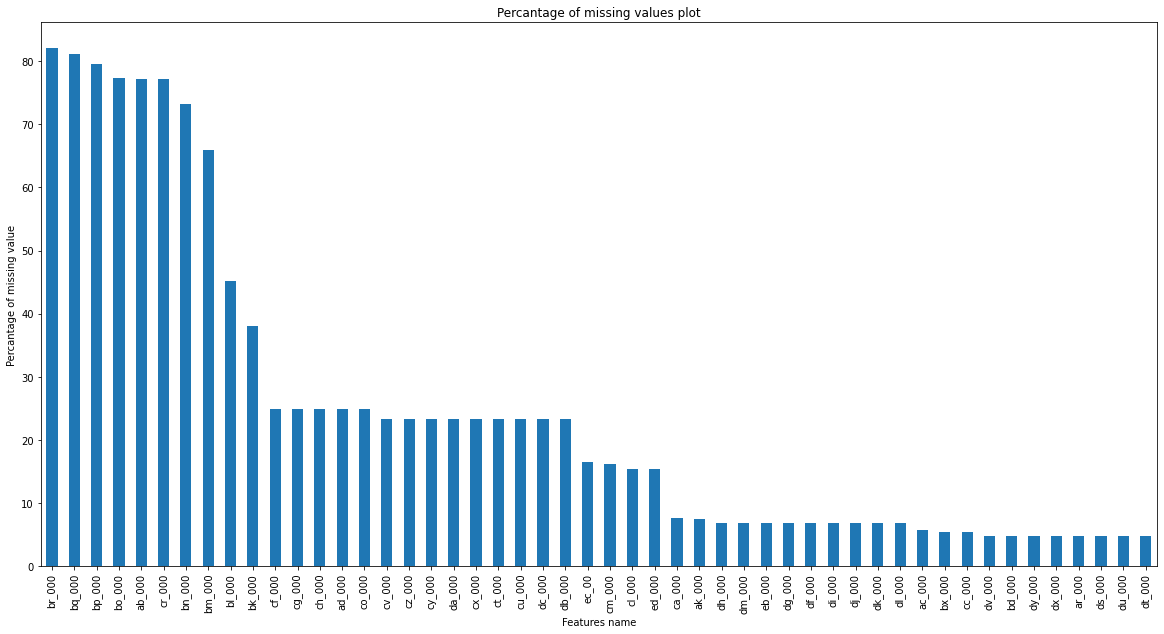

In [ ]:
# using plotbar we are ploting the feature according to the missing values
ax= test_miss_df['percent_missing'][:50].plot.bar(figsize=(20,10))
ax.set_xlabel('Features name')  # feature name on X axis
ax.set_title('Percantage of missing values plot') # title 
ax.set_ylabel('Percantage of missing value') # percentage of missing values

**Observation:** For both train data and test data

1) 8 feature have more than 60 % of data missing

2) 16 feature have 20% to 60% value missing

3) Rest feature have less than 20% missing value

# Handling Missing Data

1.  we removed those feature having missing value moer than 75 %.

2.  we used  median imputation for those feature which have less than 15 % missing values 
3.  we used KNN imputer to impute those feature which have less than 75% and more than 15% missing values.

In [ ]:
# here we are elemineting those feature which have more the 75% missing values

elemineted_feature = train_percent_missing[train_percent_missing > 75].index # here we are seperatig the those feature which have more than 75% missing value 
train_df.drop(elemineted_feature, axis = 1, inplace = True) # here we are droping the those feature 
train_df.shape

(60000, 165)

#### there are total 6 feature which have more the 75% missing values. we droped those feature.

In [ ]:
# here we are seprating those feature which have less than 15% missing values

median_imp_feature = train_percent_missing[train_percent_missing < 15].index 
median_imp_feature_df = train_df.filter(median_imp_feature) # filtering those feature which have less than 15% missing values 
median_imp_feature_df.shape

(60000, 143)

#### we find that there are total 143 feature which have less than 15% missing values 

In [ ]:
# here we are seprating and storing the those feature which have less than 75% and more than 15% missing values
model_imp_feature = train_percent_missing[(train_percent_missing < 75) & (train_percent_missing >= 15)].index 
model_imp_feature_df = train_df.filter(model_imp_feature)
model_imp_feature_df.shape

(60000, 22)

#### we find that there are total 22 feature which have less than 75% and more than 15% missing values 

### Here we are using median SimpleImputer for imputing the feature which have less than 15% missing values

In [ ]:
from sklearn.impute import SimpleImputer # importing simpleImputer
median_imputer = SimpleImputer(missing_values = np.NaN, strategy='median') # we use median strategy
median_imp_fea = median_imputer.fit_transform(median_imp_feature_df) 
median_imp_df = pd.DataFrame(median_imp_fea, columns = median_imp_feature_df.columns) # making the dataframe

### Here we are using KNN Imputer for imputing the those feature which have more than 15% and less than 75% missing values

In [ ]:
from sklearn.impute import KNNImputer # loading KNN Imputer 
imputer = KNNImputer()
model_imp_fea = imputer.fit_transform(model_imp_feature_df)
model_imp_df = pd.DataFrame(model_imp_fea, columns = model_imp_feature_df.columns)

In [ ]:
# here we are making the data frame by concat the median imputed feature and KNN Imputed features
train_imp_df = pd.concat((model_imp_df, median_imp_df), axis = 1)

In [ ]:
print(train_imp_df.shape)
train_imp_df.head(2)

(60000, 165)


,ad_000,bk_000,bl_000,bm_000,bn_000,cf_000,cg_000,ch_000,cl_000,cm_000,co_000,ct_000,cu_000,cv_000,cx_000,cy_000,cz_000,da_000,db_000,dc_000,ec_00,ed_000,class,aa_000,ac_000,ae_000,af_000,ag_000,ag_001,ag_002,ag_003,ag_004,ag_005,ag_006,ag_007,ag_008,ag_009,ah_000,ai_000,aj_000,...,cs_006,cs_007,cs_008,cs_009,dd_000,de_000,df_000,dg_000,dh_000,di_000,dj_000,dk_000,dl_000,dm_000,dn_000,do_000,dp_000,dq_000,dr_000,ds_000,dt_000,du_000,dv_000,dx_000,dy_000,dz_000,ea_000,eb_000,ee_000,ee_001,ee_002,ee_003,ee_004,ee_005,ee_006,ee_007,ee_008,ee_009,ef_000,eg_000
0,280.0,330760.0,353400.0,299160.0,305200.0,2.0,96.0,0.0,6.0,1924.0,220.0,532.0,734.0,4122704.0,51288.0,0.0,532572.0,0.0,18.0,5330690.0,2445.80,2712.0,0.0,76698.0,2.130706e+09,0.0,0.0,0.0,0.0,0.0,0.0,37250.0,1432864.0,3664156.0,1007684.0,25896.0,0.0,2551696.0,0.0,0.0,...,895240.0,26330.0,118.0,0.0,4732.0,1126.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,62282.0,85908.0,32790.0,0.0,0.0,202710.0,37928.0,14745580.0,1876644.0,0.0,0.0,0.0,0.0,2801180.0,965866.0,1706908.0,1240520.0,493384.0,721044.0,469792.0,339156.0,157956.0,73224.0,0.0,0.0,0.0
1,354.0,341420.0,359780.0,366560.0,389688.0,158.8,280.4,0.0,0.0,0.0,441.6,762.4,2077.2,3292817.6,521129.6,175.6,63387.6,0.0,0.0,4603874.8,2211.76,2334.0,0.0,33058.0,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.0,18254.0,653294.0,1720800.0,516724.0,31642.0,0.0,1393352.0,0.0,68.0,...,301242.0,9148.0,22.0,0.0,3312.0,522.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,33736.0,36946.0,5936.0,0.0,0.0,103330.0,16254.0,4510080.0,868538.0,0.0,0.0,0.0,0.0,3477820.0,664504.0,824154.0,421400.0,178064.0,293306.0,245416.0,133654.0,81140.0,97576.0,1500.0,0.0,0.0


In [ ]:
train_imp_df.to_csv('/content/drive/MyDrive/train_imp_df')

# test data preprocessing - we are doing the same process as we did in train dataset

In [ ]:
# here we are elemineting those feature which have more the 75% missing values

elemineted_feature = test_percent_missing[test_percent_missing > 75].index
test_data.drop(elemineted_feature, axis = 1, inplace = True)
test_data.shape

(16000, 165)

In [ ]:
# here we are seprating those feature which have less than 15% missing values

median_imp_feature = test_percent_missing[test_percent_missing < 15].index
median_imp_feature_df = test_data.filter(median_imp_feature)
median_imp_feature_df.shape

(16000, 143)

In [ ]:
# here we are seprating and storing the those feature which have less than 75% and more than 15% missing values
model_imp_feature = test_percent_missing[(test_percent_missing < 75) & (test_percent_missing >= 15)].index
model_imp_feature_df = test_data.filter(model_imp_feature)
model_imp_feature_df.shape

(16000, 22)

### Here we are using median SimpleImputer for imputing the feature which have less than 15% missing values

In [ ]:
median_imputer = SimpleImputer(missing_values = np.NaN, strategy='median')
median_imp_fea = median_imputer.fit_transform(median_imp_feature_df)
median_imp_df = pd.DataFrame(median_imp_fea, columns = median_imp_feature_df.columns)

In [ ]:
median_imp_df.shape

(16000, 143)

In [ ]:
median_imp_df.head(2)

,class,aa_000,ac_000,ae_000,af_000,ag_000,ag_001,ag_002,ag_003,ag_004,ag_005,ag_006,ag_007,ag_008,ag_009,ah_000,ai_000,aj_000,ak_000,al_000,am_0,an_000,ao_000,ap_000,aq_000,ar_000,as_000,at_000,au_000,av_000,ax_000,ay_000,ay_001,ay_002,ay_003,ay_004,ay_005,ay_006,ay_007,ay_008,...,cs_006,cs_007,cs_008,cs_009,dd_000,de_000,df_000,dg_000,dh_000,di_000,dj_000,dk_000,dl_000,dm_000,dn_000,do_000,dp_000,dq_000,dr_000,ds_000,dt_000,du_000,dv_000,dx_000,dy_000,dz_000,ea_000,eb_000,ee_000,ee_001,ee_002,ee_003,ee_004,ee_005,ee_006,ee_007,ee_008,ee_009,ef_000,eg_000
0,0.0,60.0,20.0,0.0,0.0,0.0,0.0,0.0,2682.0,4736.0,3862.0,1846.0,0.0,0.0,0.0,3976.0,0.0,0.0,0.0,1520.0,2374.0,11516.0,9480.0,111258.0,470.0,0.0,0.0,0.0,0.0,58.0,26.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,13124.0,...,7650.0,2294.0,206.0,0.0,70.0,112.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,340.0,0.0,0.0,1100.0,574.0,232.0,66.0,780.0,882.0,0.0,4.0,0.0,0.0,0.0,7502.0,3156.0,1098.0,138.0,412.0,654.0,78.0,88.0,0.0,0.0,0.0,0.0
1,0.0,82.0,68.0,0.0,0.0,0.0,0.0,0.0,0.0,748.0,12594.0,3636.0,0.0,0.0,0.0,5244.0,0.0,60.0,0.0,0.0,0.0,23174.0,18166.0,23686.0,1270.0,0.0,0.0,0.0,0.0,12.0,82.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,692.0,16286.0,...,9622.0,2174.0,80.0,0.0,78.0,40.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,352.0,0.0,0.0,3996.0,584.0,200.0,62.0,37580.0,3756.0,6368.0,36.0,0.0,0.0,0.0,10040.0,3310.0,1068.0,276.0,1620.0,116.0,86.0,462.0,0.0,0.0,0.0,0.0


### Here we are using KNN Imputer for imputing the those feature which have more than 15% and less than 75% missing values

In [ ]:
from sklearn.impute import KNNImputer
imputer = KNNImputer()
model_imp_test = imputer.fit_transform(model_imp_feature_df)
model_imp_df = pd.DataFrame(model_imp_test, columns = model_imp_feature_df.columns)


In [ ]:
model_imp_df.head(2)

,ad_000,bk_000,bl_000,bm_000,bn_000,cf_000,cg_000,ch_000,cl_000,cm_000,co_000,ct_000,cu_000,cv_000,cx_000,cy_000,cz_000,da_000,db_000,dc_000,ec_00,ed_000
0,12.0,0.0,0.0,0.0,0.0,0.0,6.0,0.0,6.0,30.0,8.0,22.0,42.0,5336.0,1276.0,0.0,0.0,0.0,0.0,6598.0,465.50,90.0
1,40.0,0.0,0.0,0.0,0.0,2.0,4.0,0.0,0.0,42.0,14.0,80.0,206.0,7802.0,1466.0,0.0,0.0,0.0,0.0,7918.0,2.86,102.0


In [ ]:
# here we are concating the model imputed feature and median imputed feature
test_imp_df = pd.concat((model_imp_df, median_imp_df), axis = 1)
test_imp_df.head()

,ad_000,bk_000,bl_000,bm_000,bn_000,cf_000,cg_000,ch_000,cl_000,cm_000,co_000,ct_000,cu_000,cv_000,cx_000,cy_000,cz_000,da_000,db_000,dc_000,ec_00,ed_000,class,aa_000,ac_000,ae_000,af_000,ag_000,ag_001,ag_002,ag_003,ag_004,ag_005,ag_006,ag_007,ag_008,ag_009,ah_000,ai_000,aj_000,...,cs_006,cs_007,cs_008,cs_009,dd_000,de_000,df_000,dg_000,dh_000,di_000,dj_000,dk_000,dl_000,dm_000,dn_000,do_000,dp_000,dq_000,dr_000,ds_000,dt_000,du_000,dv_000,dx_000,dy_000,dz_000,ea_000,eb_000,ee_000,ee_001,ee_002,ee_003,ee_004,ee_005,ee_006,ee_007,ee_008,ee_009,ef_000,eg_000
0,12.0,0.0,0.0,0.0,0.0,0.0,6.0,0.0,6.0,30.0,8.0,22.0,42.0,5336.0,1276.0,0.0,0.0,0.0,0.0,6598.0,465.50,90.0,0.0,60.0,20.0,0.0,0.0,0.0,0.0,0.0,2682.0,4736.0,3862.0,1846.0,0.0,0.0,0.0,3976.0,0.0,0.0,...,7650.0,2294.0,206.0,0.0,70.0,112.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,340.0,0.0,0.0,1100.0,574.0,232.0,66.0,780.0,882.0,0.0,4.0,0.0,0.0,0.0,7502.0,3156.0,1098.0,138.0,412.0,654.0,78.0,88.0,0.0,0.0,0.0,0.0
1,40.0,0.0,0.0,0.0,0.0,2.0,4.0,0.0,0.0,42.0,14.0,80.0,206.0,7802.0,1466.0,0.0,0.0,0.0,0.0,7918.0,2.86,102.0,0.0,82.0,68.0,0.0,0.0,0.0,0.0,0.0,0.0,748.0,12594.0,3636.0,0.0,0.0,0.0,5244.0,0.0,60.0,...,9622.0,2174.0,80.0,0.0,78.0,40.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,352.0,0.0,0.0,3996.0,584.0,200.0,62.0,37580.0,3756.0,6368.0,36.0,0.0,0.0,0.0,10040.0,3310.0,1068.0,276.0,1620.0,116.0,86.0,462.0,0.0,0.0,0.0,0.0
2,112.0,336240.0,194360.0,245240.0,255528.0,0.0,104.0,0.0,148.0,720.0,52.0,226.0,572.0,3593728.0,1911060.0,0.0,284.0,0.0,0.0,3613906.0,2057.84,2158.0,0.0,66002.0,212.0,0.0,0.0,0.0,0.0,0.0,199486.0,1358536.0,1952422.0,452706.0,25130.0,520.0,0.0,1891670.0,0.0,0.0,...,322718.0,6080.0,14.0,0.0,4218.0,692.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,25278.0,9438.0,2504.0,10262714.0,1278664.0,109700.0,19072.0,9520.0,4902.0,4434614.0,70900.0,0.0,0.0,26002880.0,396312.0,538136.0,495076.0,380368.0,440134.0,269556.0,1315022.0,153680.0,516.0,0.0,0.0,0.0
3,936.0,176000.0,208420.0,159380.0,169364.0,0.0,144.0,0.0,0.0,0.0,1278.0,1516.0,1398.0,2050280.0,64066.0,0.0,674.0,0.0,46.0,3413978.0,1541.32,1678.0,0.0,59816.0,1010.0,0.0,0.0,0.0,0.0,0.0,0.0,123922.0,984314.0,1680050.0,1135268.0,92606.0,14038.0,1772828.0,0.0,0.0,...,926846.0,33558.0,280.0,0.0,2924.0,414.0,0.0,0.0,60.0,38710.0,0.0,0.0,0.0,0.0,27740.0,33354.0,6330.0,0.0,0.0,133542.0,21290.0,2718360.0,435370.0,0.0,0.0,0.0,0.0,1179900.0,659550.0,691580.0,540820.0,243270.0,483302.0,485332.0,431376.0,210074.0,281662.0,3232.0,0.0,0.0
4,140.0,160648.0,78068.0,82076.0,85128.0,0.0,8.0,0.0,0.0,0.0,2.0,230.0,178.0,93820.0,57312.0,44.0,4.0,0.0,0.0,95372.0,113.86,52.0,0.0,1814.0,156.0,0.0,0.0,0.0,0.0,0.0,0.0,72.0,17926.0,82834.0,3114.0,0.0,0.0,48978.0,0.0,0.0,...,63436.0,1986.0,92.0,0.0,78.0,36.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,538.0,360.0,142.0,0.0,0.0,1822.0,344.0,2140.0,394.0,13664.0,110.0,0.0,0.0,813740.0,10216.0,9958.0,7646.0,4144.0,18466.0,49782.0,3176.0,482.0,76.0,0.0,0.0,0.0


In [ ]:
# saving the test csv file 
test_imp_df.to_csv('/content/drive/MyDrive/test_imp_df')

# Selecting Top 15 features from train data using Recursive Feature Elimination(RFE)

### 1) Recursive feature elimination (RFE) is a feature selection method that fits a model and removes the weakest features until the specified number of features is reached
### 2) here I use DecisionTreeClassifier model to select the top 15 feature


In [ ]:
y = train_imp_df['class']
x = train_imp_df.drop('class', axis = 1)

In [ ]:
from sklearn.feature_selection import RFE
from sklearn.tree import DecisionTreeClassifier

def get_top_feature(x, y, n):

  model = DecisionTreeClassifier(max_depth= 5)
  rfe = RFE(estimator= model, n_features_to_select= n)
  rfe.fit(x, y)
  top_15_feature = [k for i, k in enumerate(x.columns.tolist()) if rfe.support_[i]]   
  return top_15_feature
list_of_top_15_feature = get_top_feature(x, y, 15)
print('List of top 15 feature \n:', list_of_top_15_feature)

List of top 15 feature 
: ['ag_001', 'ag_002', 'ah_000', 'am_0', 'ay_002', 'ay_005', 'ay_006', 'ay_008', 'ay_009', 'az_004', 'bi_000', 'bj_000', 'cc_000', 'cn_004', 'cn_007']


**Observation:** 

1) we can see that I have get top 15 features from the all feature.

2) In our datasets have total 170 features, out of 170 features 70 are histogram feature and 100 numerical features

3) out of top 15 feature there are 9 feature are histogram feature and 6 are numerical features

4) it means histograme features are most imprtant feature  than numerical feature


## here I filter the those top 15 feature which are selecting from train_imp.

In [ ]:
train_top_feature = train_imp_df.filter(['class','ag_001', 'ag_002', 'ah_000', 'am_0', 'as_000', 'ay_001', 'ay_005', 'ay_008', 'ay_009', 'az_004', 'bj_000', 'cc_000', 'cn_002', 'cn_007', 'ee_002'], axis =1)

In [ ]:
train_top_feature.shape

(60000, 16)

In [ ]:
train_top_feature.head()

,class,ag_001,ag_002,ah_000,am_0,as_000,ay_001,ay_005,ay_008,ay_009,az_004,bj_000,cc_000,cn_002,cn_007,ee_002
0,0.0,0.0,0.0,2551696.0,0.0,0.0,0.0,469014.0,755876.0,0.0,615248.0,799478.0,6167850.0,0.0,98822.0,1240520.0
1,0.0,0.0,0.0,1393352.0,0.0,0.0,0.0,71510.0,99560.0,0.0,1010074.0,392208.0,2942850.0,38.0,36294.0,421400.0
2,0.0,0.0,0.0,1234132.0,0.0,0.0,0.0,0.0,1450312.0,0.0,1811606.0,139730.0,2560566.0,0.0,10260.0,277378.0
3,0.0,0.0,0.0,2668.0,3894.0,0.0,0.0,0.0,5596.0,0.0,76.0,3090.0,7710.0,2544.0,0.0,240.0
4,0.0,0.0,0.0,1974038.0,0.0,0.0,0.0,372236.0,584074.0,0.0,30194.0,399410.0,3946944.0,356.0,10482.0,622012.0


# Correlation matrix 


In [ ]:
train_top_feature_without_softimpute = train_df.filter(['class','ag_001', 'ag_002', 'ah_000', 'am_0', 'as_000', 'ay_001', 'ay_005', 'ay_008', 'ay_009', 'az_004', 'bj_000', 'cc_000', 'cn_002', 'cn_007', 'ee_002'], axis =1)

In [ ]:
train_top_feature_without_softimpute.shape

(60000, 16)

In [ ]:
train_top_feature_without_softimpute.head(3)

,class,ag_001,ag_002,ah_000,am_0,as_000,ay_001,ay_005,ay_008,ay_009,az_004,bj_000,cc_000,cn_002,cn_007,ee_002
0,0,0,0,2551696,0,0,0,469014,755876,0,615248,799478,6167850,0,98822,1240520
1,0,0,0,1393352,0,0,0,71510,99560,0,1010074,392208,2942850,38,36294,421400
2,0,0,0,1234132,0,0,0,0,1450312,0,1811606,139730,2560566,0,10260,277378


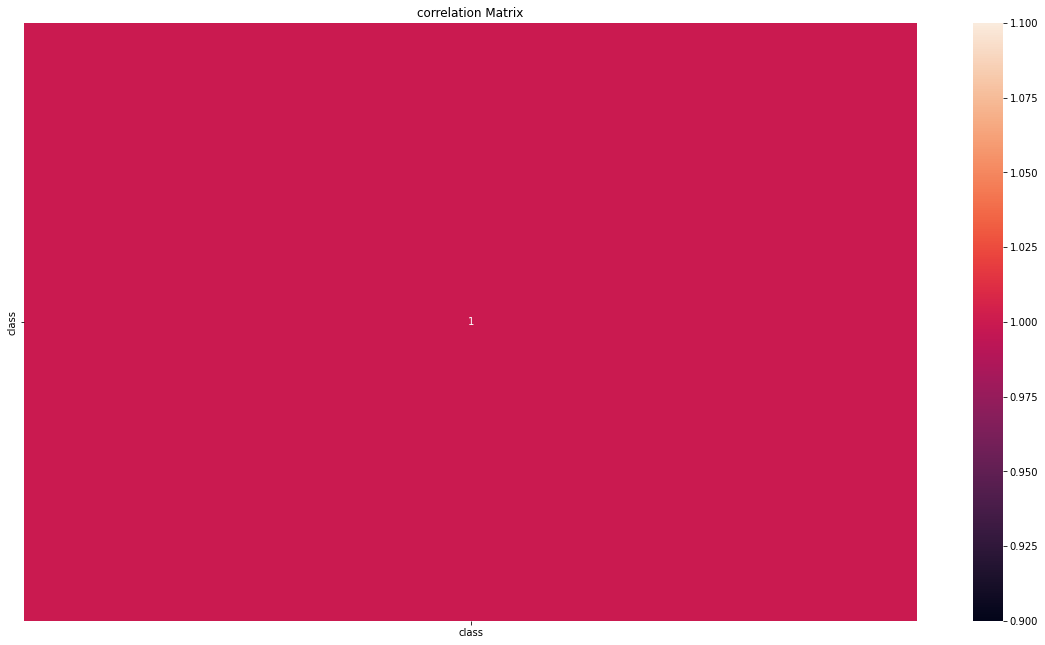

In [ ]:
import seaborn as sns
plt.figure(figsize=(20,11))
cor = train_top_feature_without_softimpute.corr()
sns.heatmap(cor, annot= True)
plt.title('correlation Matrix')
plt.show()

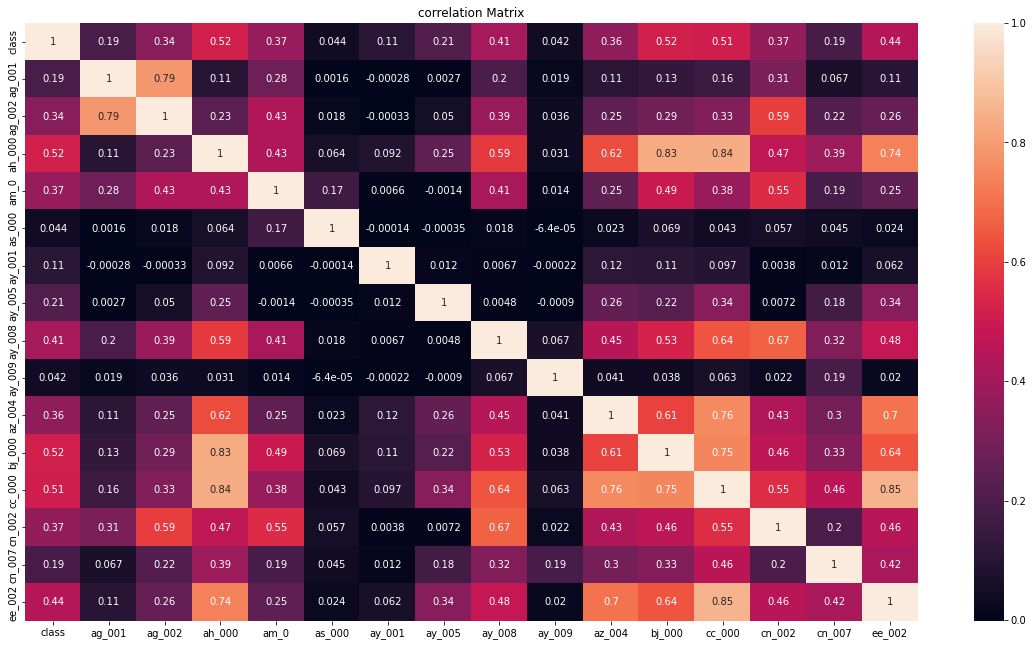

In [ ]:
import seaborn as sns
plt.figure(figsize=(20,11))
cor = train_top_feature.corr()
sns.heatmap(cor, annot= True)
plt.title('correlation Matrix')
plt.show()

**Observation before appling soft impute on train data**
1. all values looks like equaly correlated to each other 



**Observation after apply softimpute on train data** 
1. we can see that features are not highly correlated to each other.
2. In this plot we can see that some feature are not higly correlated like **ay_001 to ag_001, ay_001 to ag_002, ay_001 to as_000, ay_009 to as_000, ay_001 to cn_002, ay_005 to cn_002** 

**we can see that after applying the softimpute on train data some feature becomes more correlate to each other and some features becomes less correlate to each other**



# Bivariate Analysis of feature which are not higly correlated to each other

1. we are going to do Bivariate analysis of these feature like **ay_001 to ag_001, ay_001 to ag_002, ay_001 to as_000, ay_009 to as_000, ay_001 to cn_002, ay_005 to cn_002** 



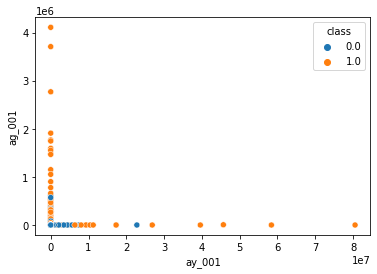

In [ ]:
# ploting scatterplot using two feature ay_001 and ag_001

sns.scatterplot(train_top_feature["ay_001"],train_top_feature["ag_001"],hue=train_top_feature["class"])


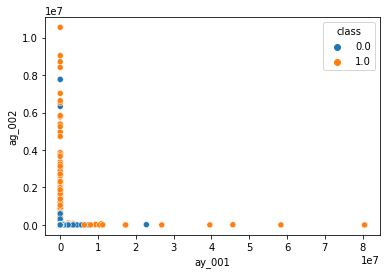

In [ ]:
#ploting scatterplot using two feature ay_001 and ag_002

sns.scatterplot(train_top_feature["ay_001"],train_top_feature["ag_002"],hue=train_top_feature["class"])

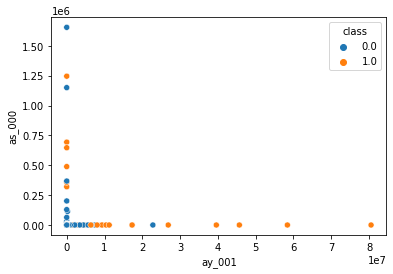

In [ ]:
#ploting scatterplot using two feature ay_001 and as_000

sns.scatterplot(train_top_feature["ay_001"],train_top_feature["as_000"],hue=train_top_feature["class"])

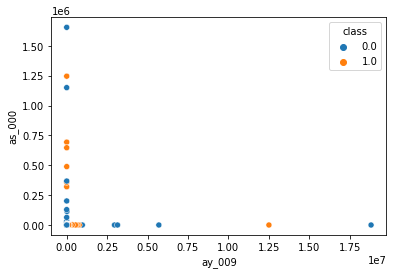

In [ ]:
#ploting scatterplot using two feature ay_009 and as_000

sns.scatterplot(train_top_feature["ay_009"],train_top_feature["as_000"],hue=train_top_feature["class"])

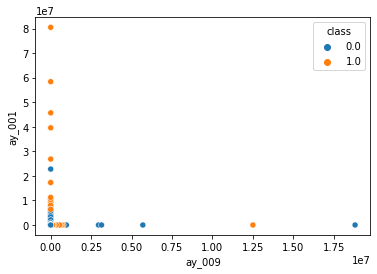

In [ ]:
#ploting scatterplot using two feature ay_009 and ay_001

sns.scatterplot(train_top_feature["ay_009"],train_top_feature["ay_001"],hue=train_top_feature["class"])

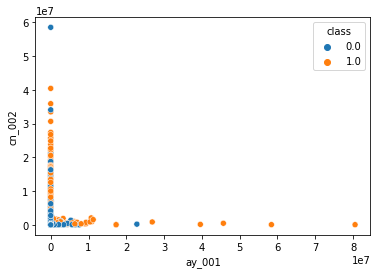

In [ ]:
#ploting scatterplot using two feature ay_001 and cn_002

sns.scatterplot(train_top_feature["ay_001"],train_top_feature["cn_002"],hue=train_top_feature["class"])

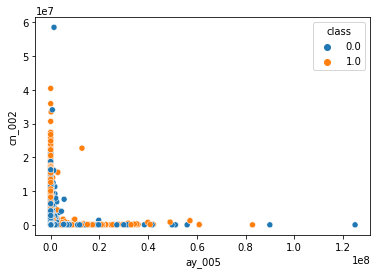

In [ ]:
#ploting scatterplot using two feature ay_005 and cn_002

sns.scatterplot(train_top_feature["ay_005"],train_top_feature["cn_002"],hue=train_top_feature["class"])

# Observation

We can see that all 9 scatter plot feature are not correlated to each other.

# Univariate analysis of the top_15 features

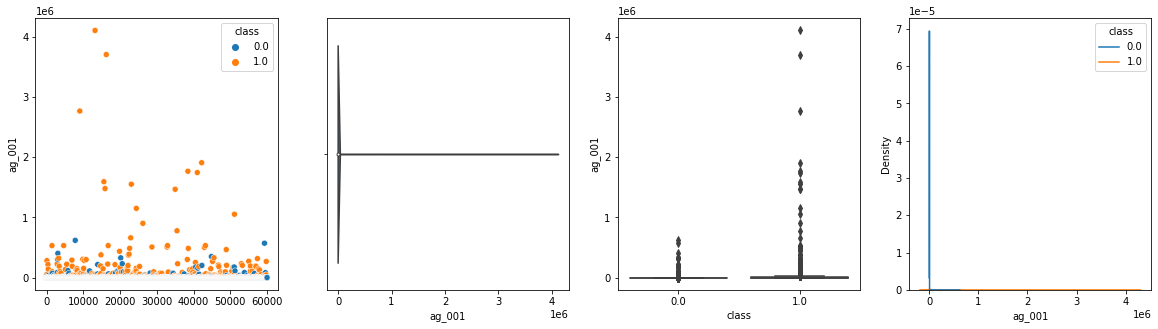

ag_001
********************************************************************************************************************************************************************************************************


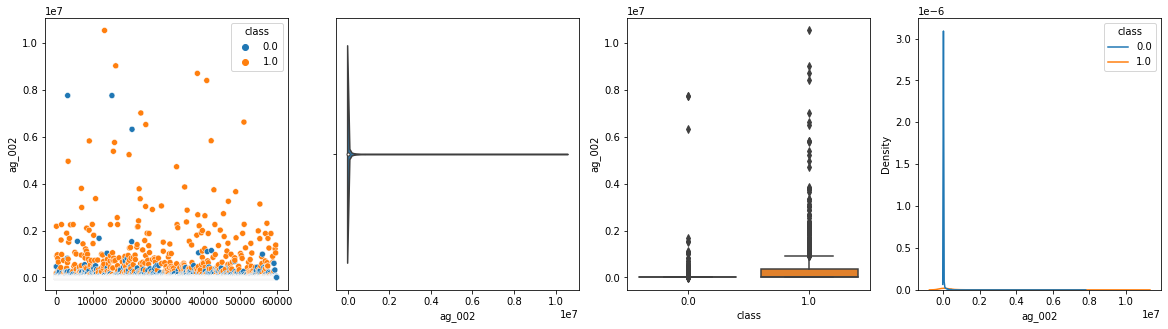

ag_002
********************************************************************************************************************************************************************************************************


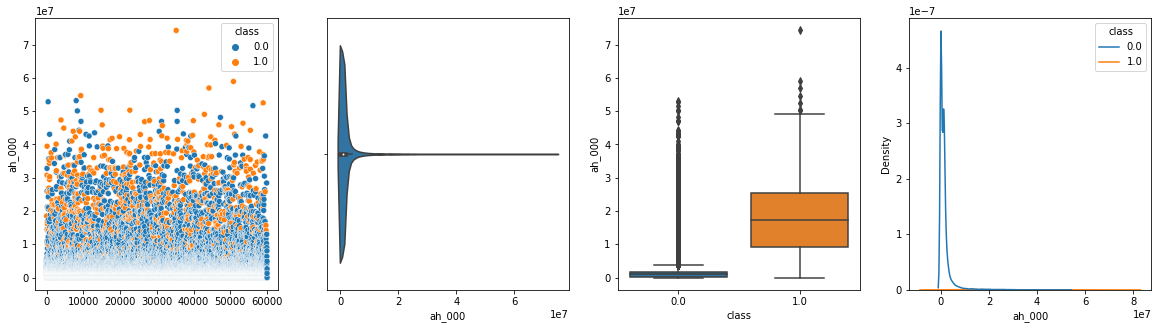

ah_000
********************************************************************************************************************************************************************************************************


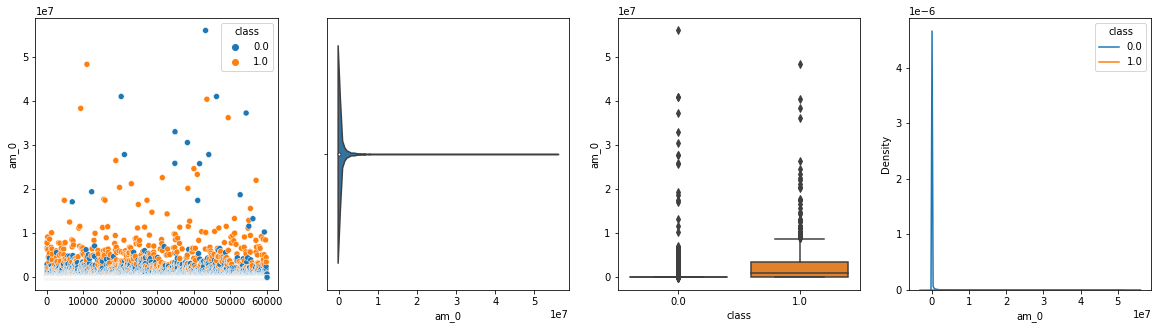

am_0
********************************************************************************************************************************************************************************************************


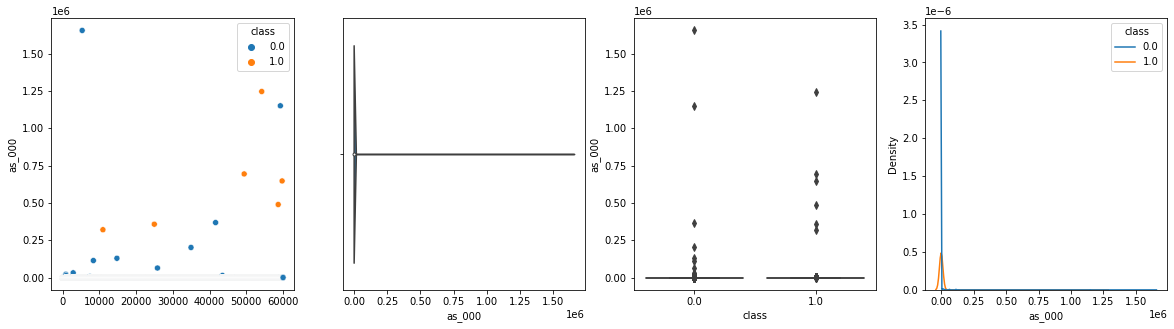

as_000
********************************************************************************************************************************************************************************************************


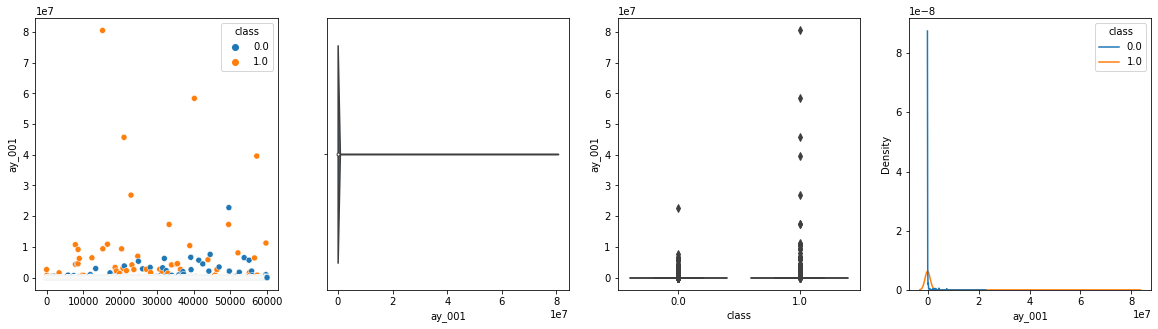

ay_001
********************************************************************************************************************************************************************************************************


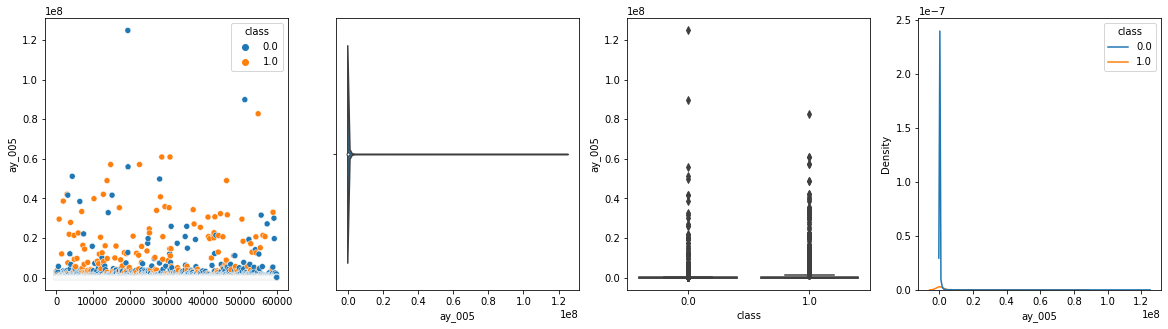

ay_005
********************************************************************************************************************************************************************************************************


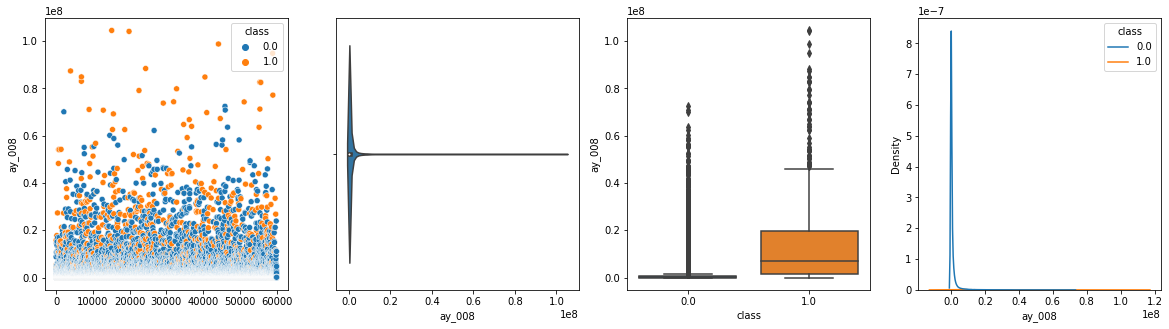

ay_008
********************************************************************************************************************************************************************************************************


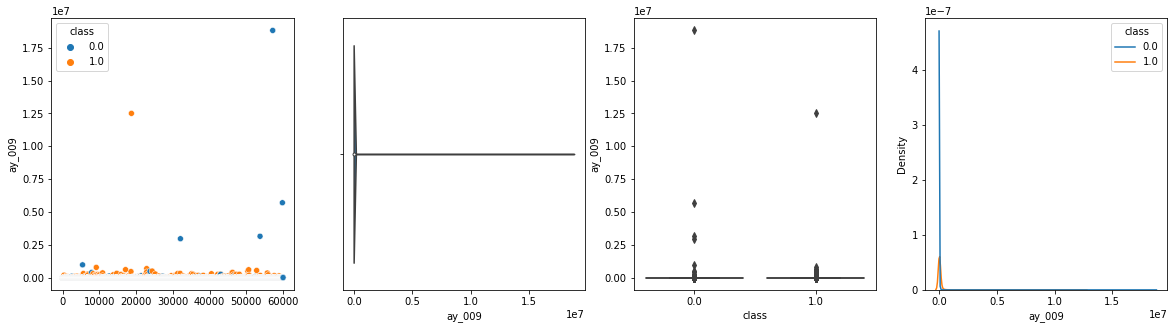

ay_009
********************************************************************************************************************************************************************************************************


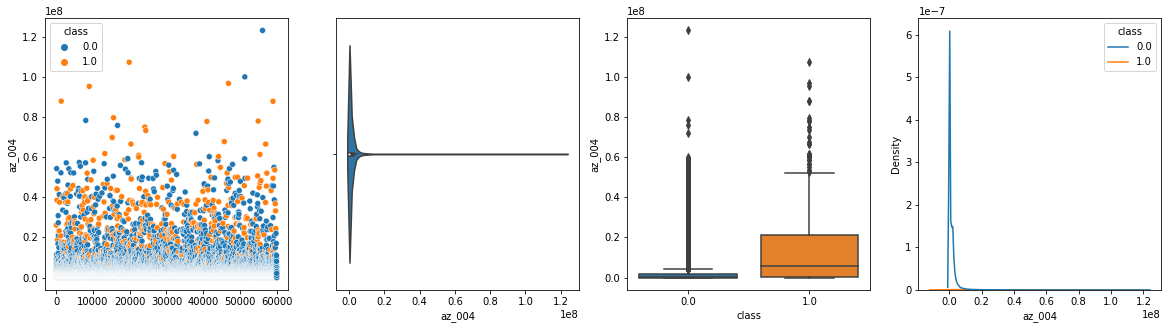

az_004
********************************************************************************************************************************************************************************************************


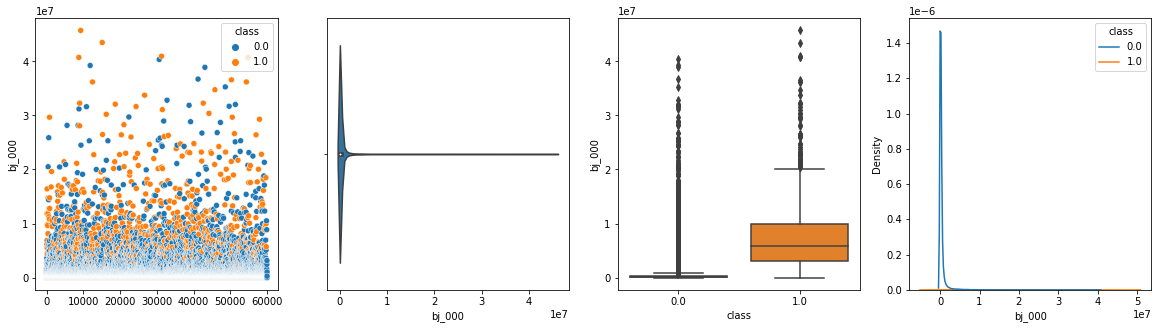

bj_000
********************************************************************************************************************************************************************************************************


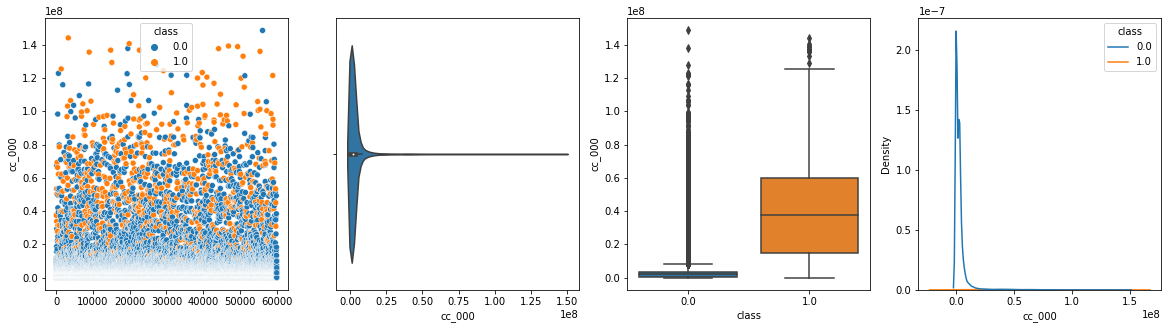

cc_000
********************************************************************************************************************************************************************************************************


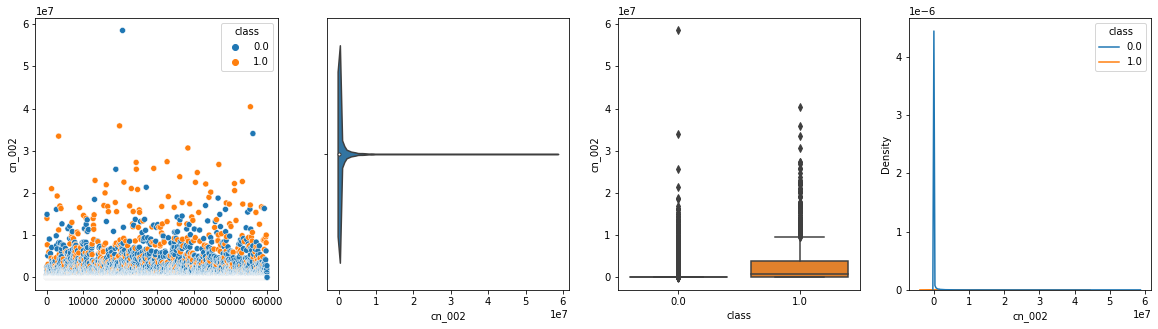

cn_002
********************************************************************************************************************************************************************************************************


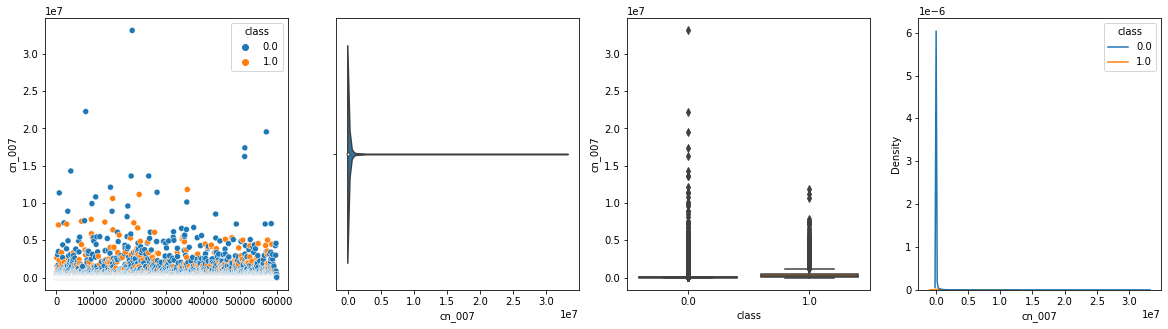

cn_007
********************************************************************************************************************************************************************************************************


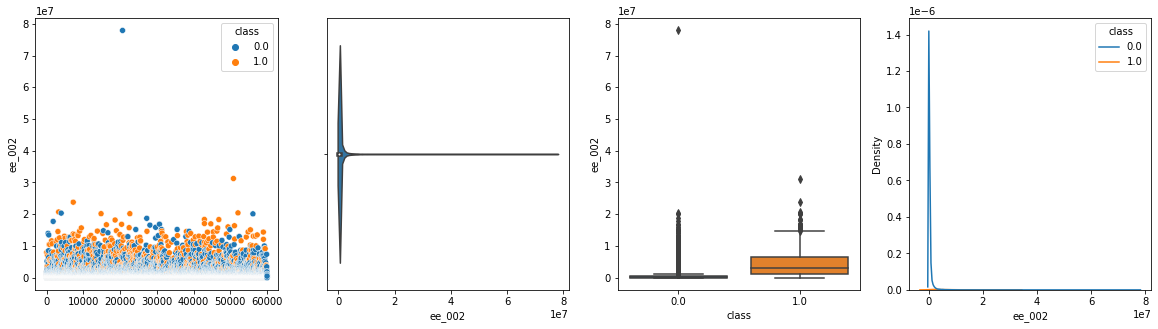

ee_002
********************************************************************************************************************************************************************************************************


In [ ]:

def feature_plot(x):
  for i in x.columns.tolist(): # we are creating list of all fature name
    if i != 'class':
      
      fig, ax = plt.subplots(1,4, figsize = (20, 5)) # here we are going to plot the 4 diff plot 

      sns.scatterplot(x.index, x[i], hue = x['class'], ax = ax[0]) # here we ploting scatter plot to visulize the data
      sns.violinplot(x = x[i], ax = ax[1]) # here we are ploting violin plot
      sns.boxplot(x = x['class'], y = x[i], ax = ax[2]) # here we ploting boxplot 
      sns.kdeplot(data = x , x = x[i], hue = 'class', ax =ax[3]) 
      plt.show()
      print(i)
      print('*'*200)
      
    

x = train_top_feature
feature_plot(x)

# Observation:

#### 1) In this feature **ag_000, ay_002**  majority of value are positive class. if we increase the value then it higher chance of APS failure.
#### 2) In this Feature **as_000, ay_001, ay_005, ay_009, cn_007** majority of values are negetive datapoint there are high chance of no failure in APS part.
#### 3) in this feature **ah_000, ay_008, cc_000, bg_000** there are very high chance of APS failure.

# analysis of the outlier in given top_15 feature 

### we can see that in our given dataset we dont have exact name and meaning of the every feature for that it become very hard to know about features and there uses. here I am going to do analysis of outlier in top 15 features



In [ ]:
print(train_top_feature.columns)

Index(['class', 'ag_001', 'ag_002', 'ah_000', 'am_0', 'as_000', 'ay_001',
       'ay_005', 'ay_008', 'ay_009', 'az_004', 'bj_000', 'cc_000', 'cn_002',
       'cn_007', 'ee_002'],
      dtype='object')


In [ ]:
def get_outlier(x):
  for i in x.columns.tolist():
    if i != 'class':
      data_dis = x[i].describe()
      min_thresold = x[i].quantile(0.05)
      max_thresold = x[i].quantile(0.95)
      print(i)
      print(data_dis)
      print(min_thresold)
      print(max_thresold)
      print('*'*200)

x = train_top_feature
get_outlier(x)

ag_001
count    6.000000e+04
mean     9.693017e+02
std      3.400916e+04
min     -1.512056e+02
25%      0.000000e+00
50%      0.000000e+00
75%      0.000000e+00
max      4.109372e+06
Name: ag_001, dtype: float64
0.0
0.0
********************************************************************************************************************************************************************************************************
ag_002
count    6.000000e+04
mean     8.552339e+03
std      1.494873e+05
min     -4.355937e+03
25%      0.000000e+00
50%      0.000000e+00
75%      0.000000e+00
max      1.055286e+07
Name: ag_002, dtype: float64
0.0
330.19963120213856
********************************************************************************************************************************************************************************************************
ah_000
count    6.000000e+04
mean     1.797480e+06
std      4.168846e+06
min      0.000000e+00
25%      2.880150e+04
50%      9.933330e+05
75% 

# Observation:

1. we can clearly see in boxplot that almost every feature have some outliers.
2. some feature like **ag_001, ag_002, as_000, ay_001, ay_009** have more than 75% value are zero. and very few value are very high. 
3. there are some like **cn_00, ay_005, am_0** have more than 50% value are zero.

# Performance Matrix

 1. The this given problem we have to calculate the Total_cost and cost function is **Total_cost = (Cost_1 * No of Instance) + (Cost_2 * No of Instance)**
 2. Where **Cost_1** is refers to the cost of Unnesary cheack of the APS system and cost_2 refers to the cost of missing a fualty APS part which may cause of a breakdown of other part also. 
 3. In given problem cost of **Cost_1** is 10 and **Cost_2** is 500.
 4. if we use F1 score as Performance Matrix then we can use False Negetive(FN) for **Cost_1** and False Positive(FP) for the **Cost_2**.
 5. After EDA I found data is higly Imbalance and there are lots of outlier for these all problem we are going to use **Macro F1 Score** as Performance Matrics.
 6. Basically In **Macro F1 Score** we calculate the individual F1 score of every variable and took the average of all F1 score and it help to deal we imbalance data.


# Feature engineering 

## Loading train and test data

In [ ]:
train_data = pd.read_csv('/content/drive/MyDrive/train_imp_df') # loading train_data
print(train_data.shape)


(60000, 166)


In [ ]:
test_data = pd.read_csv('/content/drive/MyDrive/test_imp_df') # loading test data 
print(test_data.shape)

(16000, 166)


## here we are seprating the class and feature in X, Y files

In [ ]:
# making x_train, X_test, y_train and y_test from train and test data
Y_train = train_data['class']
X_train = train_data.drop('class', axis = 1)

Y_test = test_data['class']
X_test = test_data.drop('class', axis = 1)

In [ ]:
print(Y_train.shape)
print(X_train.shape)
print(Y_test.shape)
print(X_test.shape)

(60000,)
(60000, 165)
(16000,)
(16000, 165)


## Here we are doing scaling of train and test data using standard scaler
Standardization used to scale the feature values. In standardization functionality does not limit value between 0 and 1, so any outlier in data will not be impacted due to this transformation

In [ ]:
# scaling the X_train and X_test data
from sklearn.preprocessing import StandardScaler
scalar =StandardScaler()
scalar.fit(X_train)

X_train_std = scalar.transform(X_train) # 
X_test_std = scalar.transform(X_test)

X_train_std = pd.DataFrame(X_train_std, columns = X_train.columns)
X_test_std = pd.DataFrame(X_test_std, columns = X_test.columns)


## Here we are using the PCA for feature extraction
Principal Component Analysis (PCA) is one of the most commonly used unsupervised machine learning algorithms across a variety of applications: exploratory data analysis, dimensionality reduction, information compression, data de-noising.

In [ ]:
from numpy import random
from sklearn.decomposition import PCA

pca = PCA(n_components= 0.95) # here we reducing the dimension of the data with 95% of varience
pca.fit_transform(X_train_std)

X_train_pca = pca.transform(X_train_std)
X_test_pca = pca.transform(X_test_std)

In [ ]:
X_train_pca.shape

(60000, 80)

here we can see that we reduced the 50% of the fature and we create the 80 new feature with 95% variance

In [ ]:
X_test_pca.shape

(16000, 80)

In [ ]:
X_train_pca = pd.DataFrame(X_train_pca)
X_test_pca = pd.DataFrame(X_test_pca)


In [ ]:
X_train_pca.head(2)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79
0,2.424037,-1.781991,-1.924409,-0.220769,1.052864,-0.308300,0.196385,0.010110,0.344692,0.098782,-0.559783,-0.052007,-0.127386,-0.255914,0.043667,-0.146390,0.234574,0.338212,0.393974,0.501486,0.245279,-0.771229,-0.068218,-0.529762,-0.607123,-0.200093,-0.188762,0.494853,0.061891,-0.230712,0.819357,0.372508,1.538903,0.917642,0.365876,-0.286051,-0.332112,-0.668684,1.953570,-0.483015,-0.601529,-0.269995,0.247385,0.458980,-0.495433,-0.323400,-0.562797,0.864639,0.174202,0.280697,-0.011568,-0.408816,-0.182478,0.361521,-0.428035,-0.364222,0.260795,-0.484213,-0.056707,0.218726,0.000991,0.354185,0.076858,0.297582,0.060494,-0.488981,0.340361,0.248103,-0.282597,-0.218073,-0.175256,0.058057,-0.232020,-0.745557,-0.019827,0.753658,-0.439609,0.168819,0.017652,-0.225193
1,-0.355140,-0.494459,-0.633625,-0.102899,0.549825,-0.488053,-0.030201,-0.008248,-0.024740,0.072605,0.105517,-0.134701,-0.072790,0.016267,0.040524,-0.231372,0.255504,-0.332677,0.477087,0.041124,0.029015,-0.426316,0.316395,0.022875,0.135550,0.067791,0.021002,0.215179,-0.332675,0.253755,-0.182367,-0.420543,-0.575803,0.162413,0.163422,0.139217,0.512676,-0.163770,1.120959,-0.026363,-0.570574,-0.974904,0.270882,-0.320482,-0.177955,0.219651,-0.161497,-0.122205,-0.207887,0.140849,-0.156123,0.401296,0.072894,0.235088,0.039733,-0.004368,0.193744,-0.084270,0.335134,-0.004942,0.029818,-0.009727,0.218359,-0.058922,0.044005,0.007626,-0.007161,0.416702,-0.088172,-0.043334,-0.391238,-0.059291,0.077449,0.397782,-0.155452,-0.753635,0.849488,-0.316895,0.162973,-0.502342


### Here we are adding the 80 feature which we find using PCA

In [ ]:
X_train_final = pd.concat((X_train_pca, X_train_std), axis = 1) # concating the pca_feature and origina feature 
X_test_final = pd.concat((X_test_pca, X_test_std), axis = 1)

In [ ]:
print(X_train_final.shape)
print(X_test_final.shape)


(60000, 245)
(16000, 245)


In [ ]:
X_train_final.head(2)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,cs_006,cs_007,cs_008,cs_009,dd_000,de_000,df_000,dg_000,dh_000,di_000,dj_000,dk_000,dl_000,dm_000,dn_000,do_000,dp_000,dq_000,dr_000,ds_000,dt_000,du_000,dv_000,dx_000,dy_000,dz_000,ea_000,eb_000,ee_000,ee_001,ee_002,ee_003,ee_004,ee_005,ee_006,ee_007,ee_008,ee_009,ef_000,eg_000
0,-3.245033,0.363052,0.925147,0.299916,-0.383716,0.448328,0.037163,-0.041685,-0.042848,0.058541,-0.013572,-0.120452,0.172103,0.177750,-0.008260,0.22192,0.100424,-0.841171,0.357731,-0.782029,-0.205243,0.046402,0.145581,0.377411,0.084042,0.013483,-0.004779,0.111790,-0.076750,-0.024656,-0.082011,-0.154539,-0.282214,-0.045168,0.139249,0.171213,0.543960,-0.093480,0.792255,0.006994,...,-0.465364,-0.179765,-0.019997,-0.004203,-0.322452,-0.212393,-0.019123,-0.025984,-0.008097,-0.083780,-0.008511,-0.026999,-0.025164,-0.027578,-0.345424,-0.461169,-0.494194,-0.045393,-0.145658,-0.430616,-0.455861,-0.342672,-0.278755,-0.183539,-0.127881,-0.019481,-0.028615,-0.220271,-0.301666,-0.304349,-0.385441,-0.388614,-0.381428,-0.351283,-0.310654,-0.199493,-0.306838,-0.175699,-0.020257,-0.02354
1,-0.876984,-0.473164,-0.533369,-0.553815,0.964213,-0.875762,-0.295314,0.008281,-0.064447,-0.109764,-0.026785,-0.059797,0.012026,0.166437,-0.065822,0.15395,0.076148,-0.470845,0.067092,-0.523872,-0.243745,0.001370,0.196004,0.344982,0.030632,-0.048016,-0.005476,-0.093073,-0.281243,0.151950,-0.243272,-0.031772,-0.406666,-0.287340,0.003686,-0.088134,-0.236587,0.077175,-1.056184,-0.063270,...,0.312516,-0.024002,-0.007914,-0.004203,-0.100199,-0.110634,-0.019123,-0.025984,-0.008116,-0.084558,-0.008511,-0.026999,-0.025164,-0.027578,-0.164054,-0.033430,-0.103583,-0.045393,-0.145658,0.065398,-0.003667,-0.326258,-0.255105,-0.186078,-0.128261,-0.019481,-0.028615,-0.168226,-0.055452,-0.100047,-0.131119,-0.105352,-0.137422,-0.052131,-0.116284,-0.105929,0.291547,-0.144478,-0.020257,-0.02354


# Ore data is highly Imbalance, to deal with imbalnce data we are using SMOTE
1. Synthetic Minority Oversampling Technique (SMOTE) is a type of data augmentation for the minority class. When we have imbalance data set then we use SMOTE to balance the data.
2. For generating the synthetics point from the minority class, we select a minority class instance ‘a’ at random and find its K nearest neighbors. The synthetics is then created by choosing one of the K nearest neighbors b at random and connecting a and b to form a line segment in the feature space. The synthetic instance are generated convex combination of the two chosen instance a and b.

In [ ]:
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
# define pipeline
over = SMOTE(sampling_strategy=0.3,random_state=42)
under = RandomUnderSampler(sampling_strategy=0.5)
steps = [('o', over), ('u', under)]
pipeline = Pipeline(steps=steps)
# transform the dataset
X_train_final, y_train_final = pipeline.fit_resample(X_train_final, Y_train)

In [ ]:
X_train_final.shape

(53100, 245)

In [ ]:
print(y_train_final.value_counts())

0.0    35400
1.0    17700
Name: class, dtype: int64


In [ ]:
train_final_data = pd.concat((X_train_final, y_train_final), axis = 1)
train_final_data.shape

(53100, 246)

### Here we are storing the final train and test data so we can use it without repeating the all process

In [ ]:
test_final_data = pd.concat((X_test_final, Y_test), axis = 1)
test_final_data.shape

(16000, 246)

In [ ]:
train_final_data.to_csv('/content/drive/MyDrive/train_final_data')
test_final_data.to_csv('/content/drive/MyDrive/test_final_data')

# Model
Here we are going to applying the Machine Learning Algorithm on our preprocessing dataset

In [ ]:
train_data = pd.read_csv('/content/drive/MyDrive/train_final_data')
test_data = pd.read_csv('/content/drive/MyDrive/test_final_data')

In [ ]:
Y_train = train_data['class']
X_train = train_data.drop('class', axis = 1)

Y_test = test_data['class']
X_test = test_data.drop('class', axis = 1)


In [ ]:
print(X_train.shape, Y_train.shape)
print(X_test.shape, Y_test.shape)

(53100, 246) (53100,)
(16000, 246) (16000,)


In [ ]:
# ploting the confusion matrics
from sklearn.metrics import confusion_matrix
def plot_confusion_matrix(x, y):
  cm = confusion_matrix(x, y)
  A =(((cm.T)/(cm.sum(axis=1))).T)
  B =(cm/cm.sum(axis=0))
  labels = [0,1]
  plt.figure(figsize=(20,5))
  plt.subplot(1,3,1);
  sns.heatmap(cm, annot=True, fmt=".3f",cmap='Blues',xticklabels=labels, yticklabels=labels)

  # Ploting Confusion Matrix
  plt.xlabel('Predicted labels')
  plt.ylabel('True labels') 
  plt.title('Confusion Matrix')
  
  # ploting Precision Matrix
  plt.subplot(1,3,2)
  sns.heatmap(B, annot=True, fmt=".3f",cmap='Blues',xticklabels=labels, yticklabels=labels)
  plt.xlabel('Predicted labels')
  plt.ylabel('True labels')
  plt.title('Precision Matrix')

  # ploting Recall Matrix
  ax = plt.subplot(1,3,3)
  sns.heatmap(A, annot=True, fmt=".3f",cmap='Blues',xticklabels=labels, yticklabels=labels)
  plt.xlabel('Predicted labels')
  plt.ylabel('True labels')
  plt.title('Recall Matrix')

  # here we are ploting False negetive, False positive and Total cost
  print("*"*50)
  print("False Positive:", cm[0][1])
  print("False Negative:", cm[1][0])
  print("Total cost:", cm[0][1] * 10 + cm[1][0] * 500)
  print("*"*50)

In [ ]:
# this function return the classification report
from sklearn.metrics import classification_report
def Classification_report(x, y):
    #y_pred = model.predict(X_test)
    print(classification_report(Y_test, y_pred))

### this is the confusion matrix function for calculating the cost and ploting the confusion matrix

# Logistic Regression

In [ ]:
# hyperparameter tunning using GridSearchCV

from sklearn.linear_model import LogisticRegression 
from sklearn import datasets,linear_model
from sklearn.model_selection import GridSearchCV

params= [{"C":[10**-3,10**-2,10**-1,10**0,10**1,10**2,10**3]}] # parameter 

clf = LogisticRegression(max_iter=300,penalty= 'l2')

model = GridSearchCV(clf,params,scoring = 'f1', cv= 5)
model.fit(X_train,Y_train)

print(model.best_estimator_)
print(model.score(X_test, Y_test))

LogisticRegression(C=1, max_iter=300)
0.6466019417475729


In [ ]:
# traing the model with best parameter
clf = LogisticRegression(n_jobs= -1,random_state=100,C= 1,penalty= 'l2')
clf.fit(X_train,Y_train)
y_pred = clf.predict(X_test) # class lable  prediction 

**************************************************
False Positive: 596
False Negative: 16
Total cost: 13960
**************************************************


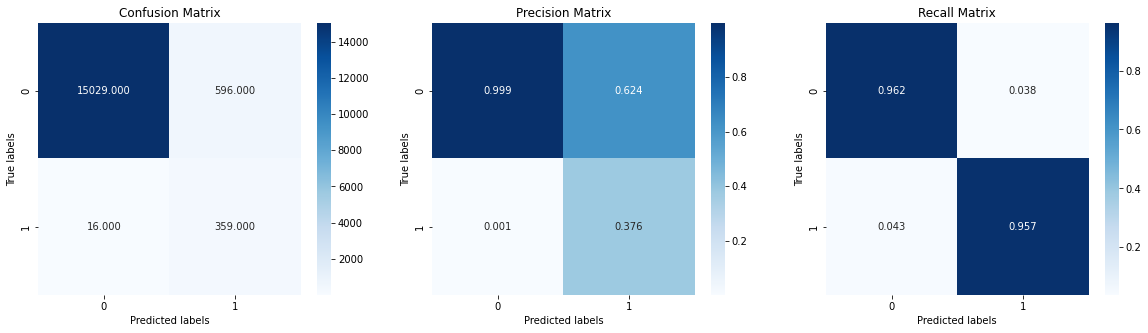

In [ ]:
# ploting the confusion matrics
plot_confusion_matrix(Y_test, y_pred)

In [ ]:
# classification report 
Classification_report(X_test, Y_test)

              precision    recall  f1-score   support

         0.0       1.00      0.96      0.98     15625
         1.0       0.38      0.95      0.55       375

    accuracy                           0.96     16000
   macro avg       0.69      0.96      0.76     16000
weighted avg       0.98      0.96      0.97     16000



Logistic Regressing Model give total cost 13960

# Random Forrest

In [ ]:
# hyper parameter tunning for Rndom Forest model
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
clf=RandomForestClassifier()


params={'n_estimators':[5,10,50, 75, 100, 200, 300],'max_depth':[5, 10, 15, 20, 25, 30]} # parameter

model=GridSearchCV(clf,param_grid=params,n_jobs=-1,scoring='f1',cv=5)
model.fit(X_train,Y_train)
print("Best estimator is", model.best_params_)

print(model.score(X_test, Y_test))

Best estimator is {'max_depth': 10, 'n_estimators': 75}
0.13366336633663367


In [ ]:
# traing the model using best parameter 
clf = RandomForestClassifier(n_jobs= -1,random_state=42, max_depth=10 ,n_estimators= 75)
clf.fit(X_train,Y_train)
y_pred = clf.predict(X_test)

**************************************************
False Positive: 31
False Negative: 202
Total cost: 101310
**************************************************


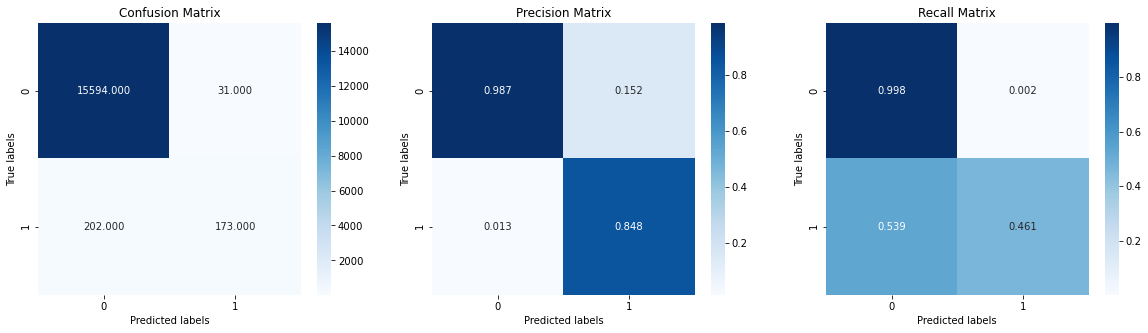

In [ ]:
# ploting confusion matrics
plot_confusion_matrix(Y_test, y_pred)

In [ ]:
# classification report
Classification_report(X_test, Y_test)

              precision    recall  f1-score   support

         0.0       0.98      1.00      0.99     15625
         1.0       0.93      0.07      0.13       375

    accuracy                           0.98     16000
   macro avg       0.95      0.54      0.56     16000
weighted avg       0.98      0.98      0.97     16000



random model gives very high false negetive value for that Total cost is very high 134110

# Decision Tree

In [ ]:
# Hyper parameter tunning for Decision Tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
clf=DecisionTreeClassifier()


tuned_parameters={'max_depth':[5,10,15,20,25]} # parameter 

model=GridSearchCV(clf,param_grid=tuned_parameters,n_jobs=-1,scoring='f1',cv=5)
model.fit(X_train,Y_train)
print("Best estimator is", model.best_params_)
print(model.score(X_test, Y_test))

Best estimator is {'max_depth': 5}
0.0


In [ ]:
# training model with best parameter 
clf = DecisionTreeClassifier(random_state=42,max_depth=5)
clf.fit(X_train,Y_train)
y_pred = clf.predict(X_test)

**************************************************
False Positive: 0
False Negative: 375
Total cost: 187500
**************************************************


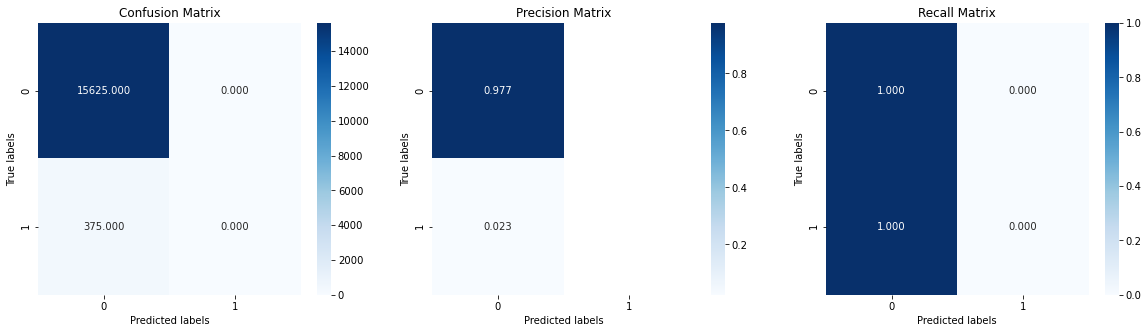

In [ ]:
# ploting confusion matrics
plot_confusion_matrix(Y_test, y_pred)

In [ ]:
# classification matrics
Classification_report(X_test, Y_test)

              precision    recall  f1-score   support

         0.0       0.98      1.00      0.99     15625
         1.0       0.00      0.00      0.00       375

    accuracy                           0.98     16000
   macro avg       0.49      0.50      0.49     16000
weighted avg       0.95      0.98      0.96     16000



Decision Tree has given False Positive 0 but False Negetive is 375 for that total cost is 187500

# XGBOOST

In [ ]:
# Hyperparametr tunning for XGBoost classifier
from xgboost import XGBClassifier

clf=XGBClassifier()
params = {'n_estimators':[200,300,500,800],'max_depth':[3,5,10]} # parameter 

model=GridSearchCV(clf, params,scoring='f1',cv=5)
model.fit(X_train,Y_train)
print("Best estimator is", model.best_params_)

[19:28:17] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[19:28:34] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[19:29:10] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[19:29:43] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

In [ ]:
# training model with best parameter 
clf = XGBClassifier(n_jobs= -1,random_state=42,max_depth=3,n_estimators= 200)
clf.fit(X_train,Y_train)
y_pred = clf.predict(X_test)

[20:29:08] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


**************************************************
False Positive: 0
False Negative: 375
Total cost: 187500
**************************************************


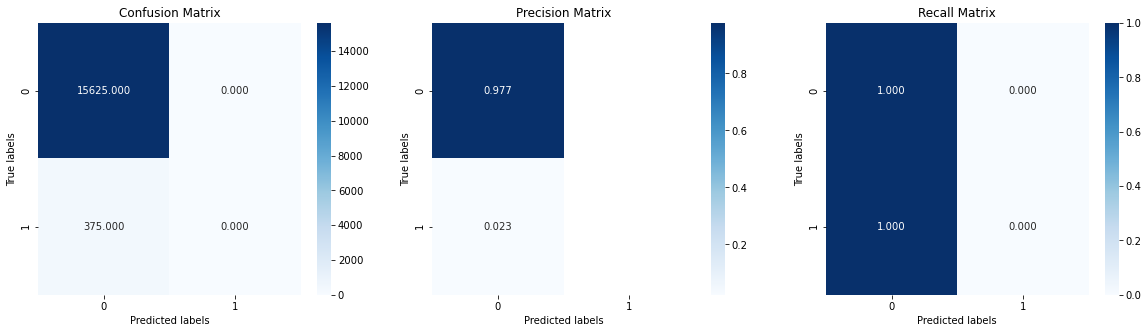

In [ ]:
# ploting confusion matrics
plot_confusion_matrix(Y_test, y_pred)

In [ ]:
# classification matrics
Classification_report(X_test, Y_test)

              precision    recall  f1-score   support

         0.0       0.98      1.00      0.99     15625
         1.0       0.00      0.00      0.00       375

    accuracy                           0.98     16000
   macro avg       0.49      0.50      0.49     16000
weighted avg       0.95      0.98      0.96     16000



XGBOOST has given False Positive 0 but False Negetive is 375 for that total cost is 187500

# Naive Bayes 

In [ ]:
# hyperparameter tunning 
clf=GaussianNB()
params = {'var_smoothing': np.random.uniform(1e-16,1e-14,100)} # parameter 
model=GridSearchCV(clf, params, scoring='f1',cv=5)
model.fit(X_train,Y_train)
print("Best estimator is", model.best_params_)

Best estimator is {'var_smoothing': 1.2485655222233953e-16}


In [ ]:
# traing model with best parameter 
clf = GaussianNB(var_smoothing = 1.2485655222233953e-16)
clf.fit(X_train,Y_train)
y_pred = clf.predict(X_test)

**************************************************
False Positive: 481
False Negative: 40
Total cost: 24810
**************************************************


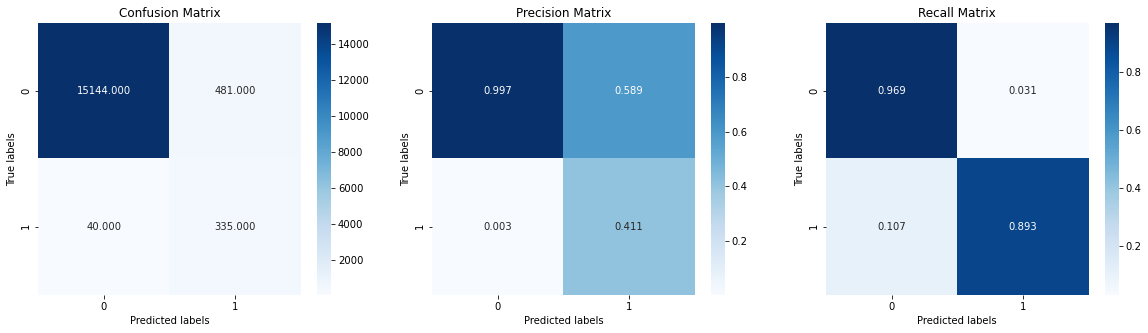

In [ ]:
# ploting cunfusion matrics
plot_confusion_matrix(Y_test, y_pred)

In [ ]:
# classification matrics
Classification_report(X_test, Y_test)

              precision    recall  f1-score   support

         0.0       1.00      0.97      0.98     15625
         1.0       0.41      0.89      0.56       375

    accuracy                           0.97     16000
   macro avg       0.70      0.93      0.77     16000
weighted avg       0.98      0.97      0.97     16000



# SDG Classifier

In [ ]:
# hyper parameter tunning 
from sklearn.linear_model import SGDClassifier
clf = SGDClassifier()
param = {'alpha': [0.0001, 0.001, 0.01, 0.1, 1, 10,  100]}
model = SGDClassifier(loss = 'hinge', penalty = 'l2', class_weight= 'balance', random_state = 42)
model = GridSearchCV(clf, param, scoring = 'f1', cv = 5)
model.fit(X_train, Y_train)
print('Best_estimator is', model.best_params_)

Best_estimator is {'alpha': 0.001}


In [ ]:
# traing model with best parameter 
clf = SGDClassifier(alpha = 0.001, penalty = 'l2', random_state = 42)
clf.fit(X_train, Y_train)
y_pred = clf.predict(X_test)

**************************************************
False Positive: 1126
False Negative: 11
Total cost: 16760
**************************************************


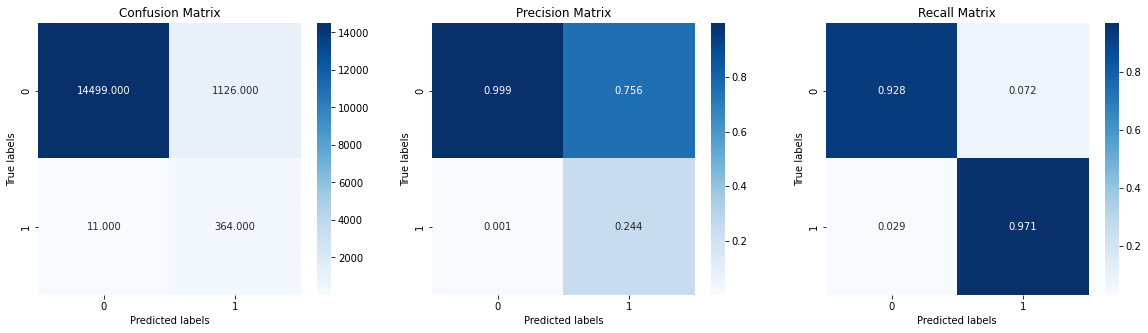

In [ ]:
# ploting cunfusion matrics
plot_confusion_matrix(Y_test, y_pred)

In [ ]:
# classificatin report
Classification_report(X_test, Y_test)

              precision    recall  f1-score   support

         0.0       1.00      0.93      0.96     15625
         1.0       0.24      0.97      0.39       375

    accuracy                           0.93     16000
   macro avg       0.62      0.95      0.68     16000
weighted avg       0.98      0.93      0.95     16000



# Stacking Classifier 

Stacking is an ensemble learning technique that uses predictions for multiple nodes(for example GaussianNB or SVM) to build a new model. This final model is used for making predictions on the test dataset.





**************************************************
False Positive: 1126
False Negative: 11
Total cost: 16760
**************************************************


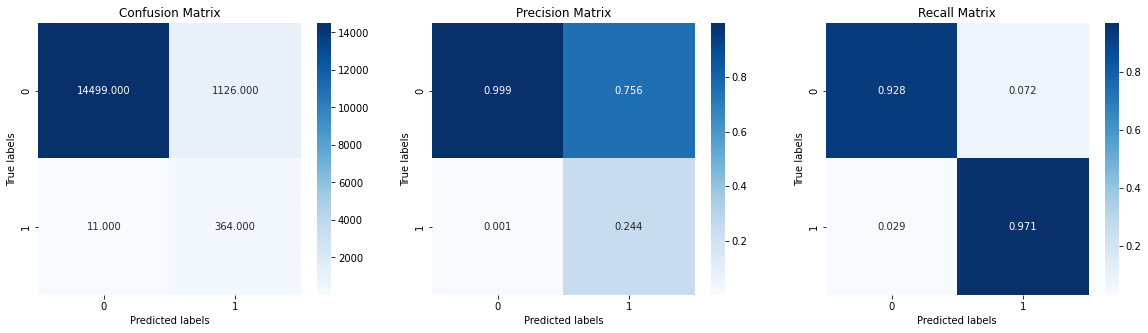

In [ ]:
from sklearn.ensemble import StackingClassifier

estimators = [('NB', GaussianNB(var_smoothing = 1.2485655222233953e-16)),
              ('SGD', SGDClassifier(alpha = 0.001, penalty = 'l2', random_state = 42))]
clf = StackingClassifier(estimators= estimators, final_estimator= LogisticRegression(n_jobs= -1,random_state=100,C= 1,penalty= 'l2'))
clf.fit(X_train, Y_train)
y_pred = clf.predict(X_test)
plot_confusion_matrix(Y_test, y_pred)

In [ ]:
Classification_report(X_test, Y_test)

              precision    recall  f1-score   support

         0.0       1.00      0.93      0.96     15625
         1.0       0.24      0.97      0.39       375

    accuracy                           0.93     16000
   macro avg       0.62      0.95      0.68     16000
weighted avg       0.98      0.93      0.95     16000



### In stacking Classifier we are using only three model which is Logistic Regression, GaussianNB and SGD classifier because these three models have performed best.

# Pretty table 

In [ ]:
from prettytable import PrettyTable
table = PrettyTable()
table.field_names = [ 'Model' , 'F1 score' ,'Test Cost']
table.add_row(['Logistic Regression Model' , 0.96, 13960])
table.add_row(['Naive Bayes' , 0.97,24810])
table.add_row(['SGDClassifier', 0.68, 16760])
table.add_row(['Decision Tree Model' , 0.98,18750])
table.add_row(['Random Forest Model' , 0.98, 101310])
table.add_row(['XGBoost Model' , 0.98,187500])
table.add_row(['StackingClassifier', 0.68, 16760])
print(table)

+---------------------------+----------+-----------+
|           Model           | F1 score | Test Cost |
+---------------------------+----------+-----------+
| Logistic Regression Model |   0.96   |   13960   |
|        Naive Bayes        |   0.97   |   24810   |
|       SGDClassifier       |   0.68   |   16760   |
|    Decision Tree Model    |   0.98   |   18750   |
|    Random Forest Model    |   0.98   |   101310  |
|       XGBoost Model       |   0.98   |   187500  |
|     StackingClassifier    |   0.68   |   16760   |
+---------------------------+----------+-----------+
